In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, Dropout, Flatten, Dense
from keras.layers import GlobalMaxPooling2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_FILE = 'data/original_train_data.h5'
METADATA = 'metadata.npy'

f = h5py.File(DATA_FILE, 'r')
data_x = f['x']
data_y = f['y']
metadata = np.load(METADATA).item()

In [3]:
from sklearn.model_selection import train_test_split

data_x = np.asarray(data_x)
data_y = np.asarray(data_y)
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.15, random_state=42)

METRICS

In [4]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    recall = recall(y_true, y_pred)
    precision = precision(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [5]:
import pandas as pd

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

CNN Model

In [6]:
lr = 1e-3
n_conv_layers = 3
n_kernels = [128] * n_conv_layers
mp_sizes = [(2,2) for _ in range(n_conv_layers)]
dropout_values = [0.25] * n_conv_layers

model = Sequential()
model.add(BatchNormalization(axis=3, input_shape=data_x.shape[1:]))
for i in range(n_conv_layers):
    model.add(Conv2D(n_kernels[i], (3, 3), padding="same", kernel_initializer="he_uniform"))
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    if i < n_conv_layers - 1:
        model.add(MaxPooling2D(mp_sizes[i]))
        model.add(Dropout(dropout_values[i]))

model.add(Conv2D(8, (3, 3), padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Activation('softmax'))
model.compile(Adam(lr), loss='categorical_crossentropy', metrics=['accuracy', recall, precision, f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 9, 15, 512)        2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 15, 128)        589952    
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 15, 128)        512       
_________________________________________________________________
activation_1 (Activation)    (None, 9, 15, 128)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 7, 128)         147584    
__________

In [8]:
model_filepath = 'models/CNN_Model.h5'
callbacks = [ModelCheckpoint(model_filepath, monitor='val_loss', verbose=0, save_best_only=True)]
model.fit(X_train, y_train, batch_size=64, epochs=25,
          validation_data=(X_val, y_val), callbacks=callbacks)

Train on 3210 samples, validate on 567 samples
Epoch 1/25


  64/3210 [..............................] - ETA: 151s - loss: 2.2582 - acc: 0.0469 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: nan

 128/3210 [>.............................] - ETA: 102s - loss: 2.0767 - acc: 0.1875 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: nan

 192/3210 [>.............................] - ETA: 84s - loss: 1.9754 - acc: 0.2604 - recall: 0.0104 - precision: 0.2222 - f1: nan         

 256/3210 [=>............................] - ETA: 75s - loss: 1.8447 - acc: 0.3320 - recall: 0.0547 - precision: 0.3333 - f1: nan

 320/3210 [=>............................] - ETA: 69s - loss: 1.7634 - acc: 0.3688 - recall: 0.1094 - precision: 0.3867 - f1: nan

 384/3210 [==>...........................] - ETA: 64s - loss: 1.7359 - acc: 0.3854 - recall: 0.1589 - precision: 0.4125 - f1: nan

 448/3210 [===>..........................] - ETA: 61s - loss: 1.7157 - acc: 0.4018 - recall: 0.1964 - precision: 0.4323 - f1: nan

 512/3210 [===>..........................] - ETA: 58s - loss: 1.6810 - acc: 0.4180 - recall: 0.2344 - precision: 0.4523 - f1: nan

 576/3210 [====>.........................] - ETA: 55s - loss: 1.6449 - acc: 0.4340 - recall: 0.2622 - precision: 0.4671 - f1: nan

 640/3210 [====>.........................] - ETA: 53s - loss: 1.6272 - acc: 0.4422 - recall: 0.2766 - precision: 0.4757 - f1: nan

 704/3210 [=====>........................] - ETA: 51s - loss: 1.6102 - acc: 0.4503 - recall: 0.2855 - precision: 0.4898 - f1: nan

 768/3210 [======>.......................] - ETA: 49s - loss: 1.6068 - acc: 0.4440 - recall: 0.2826 - precision: 0.4871 - f1: nan

 832/3210 [======>.......................] - ETA: 47s - loss: 1.5629 - acc: 0.4651 - recall: 0.3029 - precision: 0.5244 - f1: nan

 896/3210 [=======>......................] - ETA: 45s - loss: 1.5393 - acc: 0.4743 - recall: 0.3036 - precision: 0.5399 - f1: nan

 960/3210 [=======>......................] - ETA: 44s - loss: 1.5183 - acc: 0.4813 - recall: 0.3021 - precision: 0.5519 - f1: nan

1024/3210 [========>.....................] - ETA: 42s - loss: 1.5050 - acc: 0.4873 - recall: 0.3027 - precision: 0.5674 - f1: nan

1088/3210 [=========>....................] - ETA: 41s - loss: 1.4853 - acc: 0.4954 - recall: 0.3079 - precision: 0.5800 - f1: nan

1152/3210 [=========>....................] - ETA: 40s - loss: 1.4665 - acc: 0.5026 - recall: 0.3177 - precision: 0.5898 - f1: nan

1216/3210 [==========>...................] - ETA: 39s - loss: 1.4616 - acc: 0.4992 - recall: 0.3207 - precision: 0.5929 - f1: nan

1280/3210 [==========>...................] - ETA: 37s - loss: 1.4462 - acc: 0.5039 - recall: 0.3273 - precision: 0.5977 - f1: nan

1344/3210 [===========>..................] - ETA: 36s - loss: 1.4324 - acc: 0.5060 - recall: 0.3333 - precision: 0.6030 - f1: nan

1408/3210 [============>.................] - ETA: 35s - loss: 1.4267 - acc: 0.5071 - recall: 0.3324 - precision: 0.6031 - f1: nan

1472/3210 [============>.................] - ETA: 35s - loss: 1.4106 - acc: 0.5129 - recall: 0.3376 - precision: 0.6129 - f1: nan

1536/3210 [=============>................] - ETA: 36s - loss: 1.4036 - acc: 0.5156 - recall: 0.3411 - precision: 0.6215 - f1: nan

1600/3210 [=============>................] - ETA: 34s - loss: 1.3909 - acc: 0.5181 - recall: 0.3444 - precision: 0.6314 - f1: nan

1664/3210 [==============>...............] - ETA: 33s - loss: 1.3766 - acc: 0.5228 - recall: 0.3468 - precision: 0.6394 - f1: nan

1728/3210 [===============>..............] - ETA: 31s - loss: 1.3631 - acc: 0.5272 - recall: 0.3484 - precision: 0.6477 - f1: nan

1792/3210 [===============>..............] - ETA: 30s - loss: 1.3575 - acc: 0.5268 - recall: 0.3465 - precision: 0.6540 - f1: nan

1856/3210 [================>.............] - ETA: 28s - loss: 1.3425 - acc: 0.5323 - recall: 0.3502 - precision: 0.6600 - f1: nan

1920/3210 [================>.............] - ETA: 27s - loss: 1.3314 - acc: 0.5375 - recall: 0.3536 - precision: 0.6657 - f1: nan

1984/3210 [=================>............] - ETA: 25s - loss: 1.3169 - acc: 0.5444 - recall: 0.3594 - precision: 0.6709 - f1: nan

2048/3210 [==================>...........] - ETA: 24s - loss: 1.3052 - acc: 0.5483 - recall: 0.3647 - precision: 0.6747 - f1: nan

2112/3210 [==================>...........] - ETA: 22s - loss: 1.2880 - acc: 0.5559 - recall: 0.3726 - precision: 0.6812 - f1: nan

2176/3210 [===================>..........] - ETA: 21s - loss: 1.2681 - acc: 0.5643 - recall: 0.3814 - precision: 0.6881 - f1: nan

2240/3210 [===================>..........] - ETA: 19s - loss: 1.2540 - acc: 0.5692 - recall: 0.3879 - precision: 0.6921 - f1: nan

2304/3210 [====================>.........] - ETA: 18s - loss: 1.2403 - acc: 0.5738 - recall: 0.3954 - precision: 0.6962 - f1: nan

2368/3210 [=====================>........] - ETA: 17s - loss: 1.2258 - acc: 0.5769 - recall: 0.4003 - precision: 0.6978 - f1: nan

2432/3210 [=====================>........] - ETA: 15s - loss: 1.2148 - acc: 0.5794 - recall: 0.4058 - precision: 0.7004 - f1: nan

2496/3210 [======================>.......] - ETA: 14s - loss: 1.2001 - acc: 0.5853 - recall: 0.4131 - precision: 0.7059 - f1: nan

2560/3210 [======================>.......] - ETA: 13s - loss: 1.1839 - acc: 0.5914 - recall: 0.4219 - precision: 0.7114 - f1: nan

2624/3210 [=======================>......] - ETA: 12s - loss: 1.1700 - acc: 0.5964 - recall: 0.4284 - precision: 0.7147 - f1: nan

2688/3210 [========================>.....] - ETA: 10s - loss: 1.1556 - acc: 0.6031 - recall: 0.4349 - precision: 0.7195 - f1: nan

2752/3210 [========================>.....] - ETA: 9s - loss: 1.1437 - acc: 0.6083 - recall: 0.4411 - precision: 0.7242 - f1: nan 

2816/3210 [=========================>....] - ETA: 8s - loss: 1.1309 - acc: 0.6129 - recall: 0.4485 - precision: 0.7300 - f1: nan

2880/3210 [=========================>....] - ETA: 6s - loss: 1.1192 - acc: 0.6184 - recall: 0.4542 - precision: 0.7346 - f1: nan

2944/3210 [==========================>...] - ETA: 5s - loss: 1.1101 - acc: 0.6206 - recall: 0.4589 - precision: 0.7366 - f1: nan

3008/3210 [===========================>..] - ETA: 4s - loss: 1.0972 - acc: 0.6253 - recall: 0.4654 - precision: 0.7410 - f1: nan

3072/3210 [===========================>..] - ETA: 2s - loss: 1.0838 - acc: 0.6312 - recall: 0.4730 - precision: 0.7452 - f1: nan

3136/3210 [============================>.] - ETA: 1s - loss: 1.0768 - acc: 0.6336 - recall: 0.4761 - precision: 0.7460 - f1: nan

3200/3210 [============================>.] - ETA: 0s - loss: 1.0643 - acc: 0.6375 - recall: 0.4819 - precision: 0.7496 - f1: nan

3210/3210 [==============================] - 73s - loss: 1.0625 - acc: 0.6383 - recall: 0.4829 - precision: 0.7500 - f1: nan - val_loss: 2.0509 - val_acc: 0.6737 - val_recall: 0.6684 - val_precision: 0.6844 - val_f1: 0.6763


Epoch 2/25


  64/3210 [..............................] - ETA: 110s - loss: 0.4538 - acc: 0.8438 - recall: 0.8281 - precision: 0.8983 - f1: 0.8618

 128/3210 [>.............................] - ETA: 93s - loss: 0.4507 - acc: 0.8438 - recall: 0.8281 - precision: 0.8836 - f1: 0.8549 

 192/3210 [>.............................] - ETA: 85s - loss: 0.4265 - acc: 0.8438 - recall: 0.8229 - precision: 0.8879 - f1: 0.8541

 256/3210 [=>............................] - ETA: 82s - loss: 0.4403 - acc: 0.8477 - recall: 0.8203 - precision: 0.8981 - f1: 0.8572

 320/3210 [=>............................] - ETA: 77s - loss: 0.4263 - acc: 0.8531 - recall: 0.8156 - precision: 0.9006 - f1: 0.8558

 384/3210 [==>...........................] - ETA: 74s - loss: 0.4001 - acc: 0.8672 - recall: 0.8307 - precision: 0.9143 - f1: 0.8703

 448/3210 [===>..........................] - ETA: 69s - loss: 0.4186 - acc: 0.8638 - recall: 0.8281 - precision: 0.9140 - f1: 0.8688

 512/3210 [===>..........................] - ETA: 65s - loss: 0.4190 - acc: 0.8652 - recall: 0.8262 - precision: 0.9180 - f1: 0.8694

 576/3210 [====>.........................] - ETA: 61s - loss: 0.4153 - acc: 0.8663 - recall: 0.8212 - precision: 0.9208 - f1: 0.8678

 640/3210 [====>.........................] - ETA: 58s - loss: 0.4083 - acc: 0.8672 - recall: 0.8250 - precision: 0.9189 - f1: 0.8690

 704/3210 [=====>........................] - ETA: 56s - loss: 0.4070 - acc: 0.8693 - recall: 0.8253 - precision: 0.9199 - f1: 0.8697

 768/3210 [======>.......................] - ETA: 54s - loss: 0.4010 - acc: 0.8711 - recall: 0.8255 - precision: 0.9221 - f1: 0.8708

 832/3210 [======>.......................] - ETA: 56s - loss: 0.3934 - acc: 0.8738 - recall: 0.8281 - precision: 0.9241 - f1: 0.8732

 896/3210 [=======>......................] - ETA: 58s - loss: 0.3867 - acc: 0.8728 - recall: 0.8292 - precision: 0.9258 - f1: 0.8746

 960/3210 [=======>......................] - ETA: 56s - loss: 0.3751 - acc: 0.8771 - recall: 0.8344 - precision: 0.9307 - f1: 0.8796

1024/3210 [========>.....................] - ETA: 53s - loss: 0.3842 - acc: 0.8721 - recall: 0.8281 - precision: 0.9241 - f1: 0.8732

1088/3210 [=========>....................] - ETA: 51s - loss: 0.3771 - acc: 0.8759 - recall: 0.8346 - precision: 0.9266 - f1: 0.8779

1152/3210 [=========>....................] - ETA: 49s - loss: 0.3745 - acc: 0.8767 - recall: 0.8368 - precision: 0.9262 - f1: 0.8789

1216/3210 [==========>...................] - ETA: 46s - loss: 0.3671 - acc: 0.8799 - recall: 0.8421 - precision: 0.9275 - f1: 0.8824

1280/3210 [==========>...................] - ETA: 44s - loss: 0.3643 - acc: 0.8805 - recall: 0.8430 - precision: 0.9270 - f1: 0.8826

1344/3210 [===========>..................] - ETA: 42s - loss: 0.3587 - acc: 0.8824 - recall: 0.8452 - precision: 0.9281 - f1: 0.8843

1408/3210 [============>.................] - ETA: 40s - loss: 0.3566 - acc: 0.8842 - recall: 0.8473 - precision: 0.9298 - f1: 0.8863

1472/3210 [============>.................] - ETA: 38s - loss: 0.3511 - acc: 0.8865 - recall: 0.8505 - precision: 0.9308 - f1: 0.8885

1536/3210 [=============>................] - ETA: 36s - loss: 0.3459 - acc: 0.8887 - recall: 0.8535 - precision: 0.9316 - f1: 0.8905

1600/3210 [=============>................] - ETA: 35s - loss: 0.3447 - acc: 0.8906 - recall: 0.8556 - precision: 0.9337 - f1: 0.8926

1664/3210 [==============>...............] - ETA: 33s - loss: 0.3429 - acc: 0.8924 - recall: 0.8576 - precision: 0.9344 - f1: 0.8939

1728/3210 [===============>..............] - ETA: 31s - loss: 0.3404 - acc: 0.8929 - recall: 0.8594 - precision: 0.9344 - f1: 0.8949

1792/3210 [===============>..............] - ETA: 30s - loss: 0.3345 - acc: 0.8940 - recall: 0.8616 - precision: 0.9356 - f1: 0.8967

1856/3210 [================>.............] - ETA: 28s - loss: 0.3333 - acc: 0.8944 - recall: 0.8615 - precision: 0.9344 - f1: 0.8961

1920/3210 [================>.............] - ETA: 27s - loss: 0.3288 - acc: 0.8948 - recall: 0.8625 - precision: 0.9349 - f1: 0.8969

1984/3210 [=================>............] - ETA: 25s - loss: 0.3247 - acc: 0.8972 - recall: 0.8654 - precision: 0.9360 - f1: 0.8989

2048/3210 [==================>...........] - ETA: 24s - loss: 0.3236 - acc: 0.8975 - recall: 0.8662 - precision: 0.9359 - f1: 0.8993

2112/3210 [==================>...........] - ETA: 22s - loss: 0.3215 - acc: 0.8973 - recall: 0.8670 - precision: 0.9359 - f1: 0.8997

2176/3210 [===================>..........] - ETA: 21s - loss: 0.3246 - acc: 0.8957 - recall: 0.8658 - precision: 0.9344 - f1: 0.8984

2240/3210 [===================>..........] - ETA: 20s - loss: 0.3181 - acc: 0.8982 - recall: 0.8692 - precision: 0.9358 - f1: 0.9009

2304/3210 [====================>.........] - ETA: 18s - loss: 0.3150 - acc: 0.8993 - recall: 0.8694 - precision: 0.9366 - f1: 0.9013

2368/3210 [=====================>........] - ETA: 17s - loss: 0.3119 - acc: 0.9012 - recall: 0.8712 - precision: 0.9375 - f1: 0.9027

2432/3210 [=====================>........] - ETA: 15s - loss: 0.3125 - acc: 0.9013 - recall: 0.8713 - precision: 0.9378 - f1: 0.9029

2496/3210 [======================>.......] - ETA: 14s - loss: 0.3156 - acc: 0.8990 - recall: 0.8690 - precision: 0.9358 - f1: 0.9008

2560/3210 [======================>.......] - ETA: 13s - loss: 0.3148 - acc: 0.9000 - recall: 0.8695 - precision: 0.9366 - f1: 0.9014

2624/3210 [=======================>......] - ETA: 11s - loss: 0.3123 - acc: 0.9013 - recall: 0.8712 - precision: 0.9370 - f1: 0.9025

2688/3210 [========================>.....] - ETA: 10s - loss: 0.3113 - acc: 0.9010 - recall: 0.8713 - precision: 0.9365 - f1: 0.9023

2752/3210 [========================>.....] - ETA: 9s - loss: 0.3092 - acc: 0.9015 - recall: 0.8721 - precision: 0.9372 - f1: 0.9031 

2816/3210 [=========================>....] - ETA: 7s - loss: 0.3097 - acc: 0.9013 - recall: 0.8722 - precision: 0.9371 - f1: 0.9031

2880/3210 [=========================>....] - ETA: 6s - loss: 0.3080 - acc: 0.9028 - recall: 0.8722 - precision: 0.9381 - f1: 0.9036

2944/3210 [==========================>...] - ETA: 5s - loss: 0.3049 - acc: 0.9042 - recall: 0.8740 - precision: 0.9391 - f1: 0.9050

3008/3210 [===========================>..] - ETA: 4s - loss: 0.3024 - acc: 0.9053 - recall: 0.8750 - precision: 0.9401 - f1: 0.9060

3072/3210 [===========================>..] - ETA: 2s - loss: 0.3006 - acc: 0.9062 - recall: 0.8763 - precision: 0.9406 - f1: 0.9070

3136/3210 [============================>.] - ETA: 1s - loss: 0.2983 - acc: 0.9069 - recall: 0.8776 - precision: 0.9406 - f1: 0.9076

3200/3210 [============================>.] - ETA: 0s - loss: 0.2984 - acc: 0.9069 - recall: 0.8781 - precision: 0.9405 - f1: 0.9079

3210/3210 [==============================] - 67s - loss: 0.2976 - acc: 0.9072 - recall: 0.8785 - precision: 0.9407 - f1: 0.9081 - val_loss: 0.4034 - val_acc: 0.8836 - val_recall: 0.8624 - val_precision: 0.9076 - val_f1: 0.8842


Epoch 3/25


  64/3210 [..............................] - ETA: 54s - loss: 0.1123 - acc: 0.9688 - recall: 0.9688 - precision: 0.9688 - f1: 0.9688

 128/3210 [>.............................] - ETA: 52s - loss: 0.1064 - acc: 0.9766 - recall: 0.9766 - precision: 0.9766 - f1: 0.9766

 192/3210 [>.............................] - ETA: 57s - loss: 0.1109 - acc: 0.9740 - recall: 0.9740 - precision: 0.9740 - f1: 0.9740

 256/3210 [=>............................] - ETA: 59s - loss: 0.1038 - acc: 0.9766 - recall: 0.9766 - precision: 0.9805 - f1: 0.9785

 320/3210 [=>............................] - ETA: 59s - loss: 0.0910 - acc: 0.9812 - recall: 0.9812 - precision: 0.9844 - f1: 0.9828

 384/3210 [==>...........................] - ETA: 58s - loss: 0.0949 - acc: 0.9766 - recall: 0.9766 - precision: 0.9792 - f1: 0.9779

 448/3210 [===>..........................] - ETA: 56s - loss: 0.0927 - acc: 0.9777 - recall: 0.9777 - precision: 0.9799 - f1: 0.9788

 512/3210 [===>..........................] - ETA: 55s - loss: 0.0955 - acc: 0.9766 - recall: 0.9766 - precision: 0.9804 - f1: 0.9785

 576/3210 [====>.........................] - ETA: 54s - loss: 0.0945 - acc: 0.9792 - recall: 0.9792 - precision: 0.9826 - f1: 0.9809

 640/3210 [====>.........................] - ETA: 53s - loss: 0.0902 - acc: 0.9812 - recall: 0.9797 - precision: 0.9844 - f1: 0.9820

 704/3210 [=====>........................] - ETA: 53s - loss: 0.0933 - acc: 0.9801 - recall: 0.9773 - precision: 0.9829 - f1: 0.9801

 768/3210 [======>.......................] - ETA: 52s - loss: 0.1010 - acc: 0.9779 - recall: 0.9753 - precision: 0.9804 - f1: 0.9778

 832/3210 [======>.......................] - ETA: 51s - loss: 0.1031 - acc: 0.9772 - recall: 0.9736 - precision: 0.9795 - f1: 0.9765

 896/3210 [=======>......................] - ETA: 50s - loss: 0.1109 - acc: 0.9732 - recall: 0.9699 - precision: 0.9764 - f1: 0.9731

 960/3210 [=======>......................] - ETA: 48s - loss: 0.1149 - acc: 0.9708 - recall: 0.9677 - precision: 0.9748 - f1: 0.9712

1024/3210 [========>.....................] - ETA: 46s - loss: 0.1148 - acc: 0.9697 - recall: 0.9658 - precision: 0.9754 - f1: 0.9705

1088/3210 [=========>....................] - ETA: 44s - loss: 0.1131 - acc: 0.9697 - recall: 0.9651 - precision: 0.9759 - f1: 0.9704

1152/3210 [=========>....................] - ETA: 43s - loss: 0.1127 - acc: 0.9696 - recall: 0.9653 - precision: 0.9763 - f1: 0.9707

1216/3210 [==========>...................] - ETA: 42s - loss: 0.1138 - acc: 0.9696 - recall: 0.9646 - precision: 0.9759 - f1: 0.9702

1280/3210 [==========>...................] - ETA: 40s - loss: 0.1111 - acc: 0.9703 - recall: 0.9656 - precision: 0.9763 - f1: 0.9709

1344/3210 [===========>..................] - ETA: 39s - loss: 0.1102 - acc: 0.9702 - recall: 0.9658 - precision: 0.9767 - f1: 0.9712

1408/3210 [============>.................] - ETA: 37s - loss: 0.1074 - acc: 0.9716 - recall: 0.9673 - precision: 0.9777 - f1: 0.9725

1472/3210 [============>.................] - ETA: 35s - loss: 0.1080 - acc: 0.9715 - recall: 0.9667 - precision: 0.9780 - f1: 0.9723

1536/3210 [=============>................] - ETA: 34s - loss: 0.1075 - acc: 0.9714 - recall: 0.9668 - precision: 0.9783 - f1: 0.9725

1600/3210 [=============>................] - ETA: 32s - loss: 0.1058 - acc: 0.9719 - recall: 0.9669 - precision: 0.9791 - f1: 0.9729

1664/3210 [==============>...............] - ETA: 31s - loss: 0.1044 - acc: 0.9730 - recall: 0.9669 - precision: 0.9799 - f1: 0.9734

1728/3210 [===============>..............] - ETA: 30s - loss: 0.1040 - acc: 0.9728 - recall: 0.9670 - precision: 0.9801 - f1: 0.9735

1792/3210 [===============>..............] - ETA: 28s - loss: 0.1034 - acc: 0.9732 - recall: 0.9671 - precision: 0.9802 - f1: 0.9736

1856/3210 [================>.............] - ETA: 27s - loss: 0.1050 - acc: 0.9725 - recall: 0.9666 - precision: 0.9793 - f1: 0.9729

1920/3210 [================>.............] - ETA: 26s - loss: 0.1032 - acc: 0.9729 - recall: 0.9667 - precision: 0.9795 - f1: 0.9730

1984/3210 [=================>............] - ETA: 24s - loss: 0.1022 - acc: 0.9733 - recall: 0.9672 - precision: 0.9796 - f1: 0.9734

2048/3210 [==================>...........] - ETA: 23s - loss: 0.1022 - acc: 0.9731 - recall: 0.9668 - precision: 0.9798 - f1: 0.9732

2112/3210 [==================>...........] - ETA: 21s - loss: 0.1032 - acc: 0.9721 - recall: 0.9659 - precision: 0.9785 - f1: 0.9721

2176/3210 [===================>..........] - ETA: 20s - loss: 0.1031 - acc: 0.9715 - recall: 0.9655 - precision: 0.9786 - f1: 0.9720

2240/3210 [===================>..........] - ETA: 19s - loss: 0.1033 - acc: 0.9710 - recall: 0.9647 - precision: 0.9788 - f1: 0.9717

2304/3210 [====================>.........] - ETA: 17s - loss: 0.1043 - acc: 0.9709 - recall: 0.9648 - precision: 0.9785 - f1: 0.9716

2368/3210 [=====================>........] - ETA: 16s - loss: 0.1035 - acc: 0.9713 - recall: 0.9649 - precision: 0.9786 - f1: 0.9717

2432/3210 [=====================>........] - ETA: 15s - loss: 0.1034 - acc: 0.9708 - recall: 0.9646 - precision: 0.9784 - f1: 0.9714

2496/3210 [======================>.......] - ETA: 13s - loss: 0.1044 - acc: 0.9708 - recall: 0.9647 - precision: 0.9781 - f1: 0.9713

2560/3210 [======================>.......] - ETA: 12s - loss: 0.1034 - acc: 0.9715 - recall: 0.9652 - precision: 0.9787 - f1: 0.9719

2624/3210 [=======================>......] - ETA: 11s - loss: 0.1028 - acc: 0.9718 - recall: 0.9653 - precision: 0.9788 - f1: 0.9720

2688/3210 [========================>.....] - ETA: 10s - loss: 0.1020 - acc: 0.9717 - recall: 0.9654 - precision: 0.9793 - f1: 0.9723

2752/3210 [========================>.....] - ETA: 8s - loss: 0.1012 - acc: 0.9717 - recall: 0.9655 - precision: 0.9798 - f1: 0.9725 

2816/3210 [=========================>....] - ETA: 7s - loss: 0.1023 - acc: 0.9712 - recall: 0.9652 - precision: 0.9792 - f1: 0.9721

2880/3210 [=========================>....] - ETA: 6s - loss: 0.1017 - acc: 0.9715 - recall: 0.9656 - precision: 0.9796 - f1: 0.9725

2944/3210 [==========================>...] - ETA: 5s - loss: 0.1017 - acc: 0.9715 - recall: 0.9657 - precision: 0.9801 - f1: 0.9728

3008/3210 [===========================>..] - ETA: 3s - loss: 0.1021 - acc: 0.9714 - recall: 0.9654 - precision: 0.9802 - f1: 0.9727

3072/3210 [===========================>..] - ETA: 2s - loss: 0.1016 - acc: 0.9717 - recall: 0.9658 - precision: 0.9806 - f1: 0.9731

3136/3210 [============================>.] - ETA: 1s - loss: 0.1014 - acc: 0.9716 - recall: 0.9656 - precision: 0.9803 - f1: 0.9728

3200/3210 [============================>.] - ETA: 0s - loss: 0.1028 - acc: 0.9712 - recall: 0.9647 - precision: 0.9801 - f1: 0.9723

3210/3210 [==============================] - 64s - loss: 0.1025 - acc: 0.9713 - recall: 0.9648 - precision: 0.9801 - f1: 0.9724 - val_loss: 0.2201 - val_acc: 0.9365 - val_recall: 0.9277 - val_precision: 0.9497 - val_f1: 0.9385


Epoch 4/25


  64/3210 [..............................] - ETA: 53s - loss: 0.0520 - acc: 0.9844 - recall: 0.9844 - precision: 1.0000 - f1: 0.9921

 128/3210 [>.............................] - ETA: 52s - loss: 0.0330 - acc: 0.9922 - recall: 0.9922 - precision: 1.0000 - f1: 0.9961

 192/3210 [>.............................] - ETA: 50s - loss: 0.0376 - acc: 0.9896 - recall: 0.9896 - precision: 0.9948 - f1: 0.9922

 256/3210 [=>............................] - ETA: 49s - loss: 0.0442 - acc: 0.9883 - recall: 0.9844 - precision: 0.9921 - f1: 0.9882

 320/3210 [=>............................] - ETA: 48s - loss: 0.0445 - acc: 0.9875 - recall: 0.9844 - precision: 0.9937 - f1: 0.9890

 384/3210 [==>...........................] - ETA: 49s - loss: 0.0447 - acc: 0.9896 - recall: 0.9870 - precision: 0.9948 - f1: 0.9908

 448/3210 [===>..........................] - ETA: 49s - loss: 0.0417 - acc: 0.9911 - recall: 0.9888 - precision: 0.9955 - f1: 0.9921

 512/3210 [===>..........................] - ETA: 47s - loss: 0.0417 - acc: 0.9922 - recall: 0.9902 - precision: 0.9961 - f1: 0.9931

 576/3210 [====>.........................] - ETA: 47s - loss: 0.0404 - acc: 0.9913 - recall: 0.9896 - precision: 0.9948 - f1: 0.9922

 640/3210 [====>.........................] - ETA: 46s - loss: 0.0396 - acc: 0.9922 - recall: 0.9906 - precision: 0.9953 - f1: 0.9929

 704/3210 [=====>........................] - ETA: 45s - loss: 0.0473 - acc: 0.9915 - recall: 0.9901 - precision: 0.9943 - f1: 0.9922

 768/3210 [======>.......................] - ETA: 45s - loss: 0.0481 - acc: 0.9896 - recall: 0.9883 - precision: 0.9934 - f1: 0.9908

 832/3210 [======>.......................] - ETA: 43s - loss: 0.0470 - acc: 0.9904 - recall: 0.9880 - precision: 0.9940 - f1: 0.9909

 896/3210 [=======>......................] - ETA: 42s - loss: 0.0456 - acc: 0.9911 - recall: 0.9888 - precision: 0.9944 - f1: 0.9916

 960/3210 [=======>......................] - ETA: 45s - loss: 0.0484 - acc: 0.9896 - recall: 0.9875 - precision: 0.9927 - f1: 0.9901

1024/3210 [========>.....................] - ETA: 48s - loss: 0.0475 - acc: 0.9902 - recall: 0.9883 - precision: 0.9931 - f1: 0.9907

1088/3210 [=========>....................] - ETA: 46s - loss: 0.0463 - acc: 0.9899 - recall: 0.9881 - precision: 0.9926 - f1: 0.9903

1152/3210 [=========>....................] - ETA: 44s - loss: 0.0468 - acc: 0.9896 - recall: 0.9878 - precision: 0.9922 - f1: 0.9900

1216/3210 [==========>...................] - ETA: 43s - loss: 0.0452 - acc: 0.9901 - recall: 0.9885 - precision: 0.9926 - f1: 0.9905

1280/3210 [==========>...................] - ETA: 43s - loss: 0.0443 - acc: 0.9906 - recall: 0.9891 - precision: 0.9929 - f1: 0.9910

1344/3210 [===========>..................] - ETA: 41s - loss: 0.0434 - acc: 0.9911 - recall: 0.9896 - precision: 0.9933 - f1: 0.9914

1408/3210 [============>.................] - ETA: 39s - loss: 0.0470 - acc: 0.9901 - recall: 0.9872 - precision: 0.9928 - f1: 0.9900

1472/3210 [============>.................] - ETA: 38s - loss: 0.0514 - acc: 0.9898 - recall: 0.9871 - precision: 0.9925 - f1: 0.9897

1536/3210 [=============>................] - ETA: 36s - loss: 0.0500 - acc: 0.9902 - recall: 0.9876 - precision: 0.9928 - f1: 0.9902

1600/3210 [=============>................] - ETA: 34s - loss: 0.0491 - acc: 0.9900 - recall: 0.9875 - precision: 0.9931 - f1: 0.9903

1664/3210 [==============>...............] - ETA: 33s - loss: 0.0482 - acc: 0.9904 - recall: 0.9880 - precision: 0.9933 - f1: 0.9906

1728/3210 [===============>..............] - ETA: 31s - loss: 0.0485 - acc: 0.9902 - recall: 0.9878 - precision: 0.9930 - f1: 0.9904

1792/3210 [===============>..............] - ETA: 29s - loss: 0.0513 - acc: 0.9894 - recall: 0.9872 - precision: 0.9921 - f1: 0.9896

1856/3210 [================>.............] - ETA: 28s - loss: 0.0503 - acc: 0.9898 - recall: 0.9876 - precision: 0.9924 - f1: 0.9900

1920/3210 [================>.............] - ETA: 27s - loss: 0.0502 - acc: 0.9901 - recall: 0.9875 - precision: 0.9927 - f1: 0.9901

1984/3210 [=================>............] - ETA: 25s - loss: 0.0496 - acc: 0.9904 - recall: 0.9879 - precision: 0.9929 - f1: 0.9904

2048/3210 [==================>...........] - ETA: 24s - loss: 0.0496 - acc: 0.9902 - recall: 0.9878 - precision: 0.9926 - f1: 0.9902

2112/3210 [==================>...........] - ETA: 22s - loss: 0.0504 - acc: 0.9901 - recall: 0.9877 - precision: 0.9924 - f1: 0.9900

2176/3210 [===================>..........] - ETA: 21s - loss: 0.0494 - acc: 0.9903 - recall: 0.9881 - precision: 0.9926 - f1: 0.9903

2240/3210 [===================>..........] - ETA: 19s - loss: 0.0486 - acc: 0.9906 - recall: 0.9884 - precision: 0.9928 - f1: 0.9906

2304/3210 [====================>.........] - ETA: 18s - loss: 0.0480 - acc: 0.9909 - recall: 0.9887 - precision: 0.9930 - f1: 0.9908

2368/3210 [=====================>........] - ETA: 17s - loss: 0.0474 - acc: 0.9911 - recall: 0.9890 - precision: 0.9932 - f1: 0.9911

2432/3210 [=====================>........] - ETA: 15s - loss: 0.0492 - acc: 0.9905 - recall: 0.9885 - precision: 0.9926 - f1: 0.9905

2496/3210 [======================>.......] - ETA: 14s - loss: 0.0518 - acc: 0.9900 - recall: 0.9880 - precision: 0.9923 - f1: 0.9901

2560/3210 [======================>.......] - ETA: 13s - loss: 0.0514 - acc: 0.9902 - recall: 0.9883 - precision: 0.9925 - f1: 0.9904

2624/3210 [=======================>......] - ETA: 11s - loss: 0.0510 - acc: 0.9905 - recall: 0.9886 - precision: 0.9927 - f1: 0.9906

2688/3210 [========================>.....] - ETA: 10s - loss: 0.0501 - acc: 0.9907 - recall: 0.9888 - precision: 0.9929 - f1: 0.9908

2752/3210 [========================>.....] - ETA: 9s - loss: 0.0499 - acc: 0.9906 - recall: 0.9887 - precision: 0.9927 - f1: 0.9907 

2816/3210 [=========================>....] - ETA: 7s - loss: 0.0490 - acc: 0.9908 - recall: 0.9890 - precision: 0.9929 - f1: 0.9909

2880/3210 [=========================>....] - ETA: 6s - loss: 0.0498 - acc: 0.9899 - recall: 0.9882 - precision: 0.9920 - f1: 0.9901

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0491 - acc: 0.9901 - recall: 0.9885 - precision: 0.9922 - f1: 0.9903

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0489 - acc: 0.9900 - recall: 0.9884 - precision: 0.9923 - f1: 0.9903

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0488 - acc: 0.9899 - recall: 0.9883 - precision: 0.9922 - f1: 0.9902

3136/3210 [============================>.] - ETA: 1s - loss: 0.0493 - acc: 0.9895 - recall: 0.9879 - precision: 0.9917 - f1: 0.9898

3200/3210 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.9897 - recall: 0.9881 - precision: 0.9918 - f1: 0.9900

3210/3210 [==============================] - 67s - loss: 0.0489 - acc: 0.9897 - recall: 0.9882 - precision: 0.9919 - f1: 0.9900 - val_loss: 0.1799 - val_acc: 0.9612 - val_recall: 0.9594 - val_precision: 0.9646 - val_f1: 0.9620


Epoch 5/25


  64/3210 [..............................] - ETA: 55s - loss: 0.0992 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 128/3210 [>.............................] - ETA: 54s - loss: 0.0651 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 192/3210 [>.............................] - ETA: 53s - loss: 0.0524 - acc: 0.9948 - recall: 0.9948 - precision: 0.9948 - f1: 0.9948

 256/3210 [=>............................] - ETA: 51s - loss: 0.0461 - acc: 0.9961 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 320/3210 [=>............................] - ETA: 50s - loss: 0.0474 - acc: 0.9969 - recall: 0.9969 - precision: 0.9969 - f1: 0.9969

 384/3210 [==>...........................] - ETA: 53s - loss: 0.0423 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

 448/3210 [===>..........................] - ETA: 64s - loss: 0.0379 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

 512/3210 [===>..........................] - ETA: 63s - loss: 0.0369 - acc: 0.9961 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 576/3210 [====>.........................] - ETA: 60s - loss: 0.0384 - acc: 0.9931 - recall: 0.9931 - precision: 0.9948 - f1: 0.9939

 640/3210 [====>.........................] - ETA: 57s - loss: 0.0377 - acc: 0.9938 - recall: 0.9938 - precision: 0.9953 - f1: 0.9945

 704/3210 [=====>........................] - ETA: 55s - loss: 0.0353 - acc: 0.9943 - recall: 0.9943 - precision: 0.9957 - f1: 0.9950

 768/3210 [======>.......................] - ETA: 53s - loss: 0.0334 - acc: 0.9948 - recall: 0.9948 - precision: 0.9961 - f1: 0.9954

 832/3210 [======>.......................] - ETA: 50s - loss: 0.0316 - acc: 0.9952 - recall: 0.9952 - precision: 0.9964 - f1: 0.9958

 896/3210 [=======>......................] - ETA: 49s - loss: 0.0300 - acc: 0.9955 - recall: 0.9955 - precision: 0.9966 - f1: 0.9961

 960/3210 [=======>......................] - ETA: 47s - loss: 0.0289 - acc: 0.9958 - recall: 0.9958 - precision: 0.9969 - f1: 0.9963

1024/3210 [========>.....................] - ETA: 45s - loss: 0.0285 - acc: 0.9961 - recall: 0.9961 - precision: 0.9971 - f1: 0.9966

1088/3210 [=========>....................] - ETA: 43s - loss: 0.0274 - acc: 0.9963 - recall: 0.9963 - precision: 0.9972 - f1: 0.9968

1152/3210 [=========>....................] - ETA: 41s - loss: 0.0267 - acc: 0.9965 - recall: 0.9965 - precision: 0.9974 - f1: 0.9970

1216/3210 [==========>...................] - ETA: 40s - loss: 0.0259 - acc: 0.9967 - recall: 0.9967 - precision: 0.9975 - f1: 0.9971

1280/3210 [==========>...................] - ETA: 38s - loss: 0.0274 - acc: 0.9961 - recall: 0.9961 - precision: 0.9969 - f1: 0.9965

1344/3210 [===========>..................] - ETA: 37s - loss: 0.0274 - acc: 0.9955 - recall: 0.9955 - precision: 0.9963 - f1: 0.9959

1408/3210 [============>.................] - ETA: 35s - loss: 0.0264 - acc: 0.9957 - recall: 0.9957 - precision: 0.9964 - f1: 0.9961

1472/3210 [============>.................] - ETA: 34s - loss: 0.0258 - acc: 0.9959 - recall: 0.9959 - precision: 0.9966 - f1: 0.9963

1536/3210 [=============>................] - ETA: 32s - loss: 0.0254 - acc: 0.9961 - recall: 0.9961 - precision: 0.9967 - f1: 0.9964

1600/3210 [=============>................] - ETA: 31s - loss: 0.0252 - acc: 0.9962 - recall: 0.9962 - precision: 0.9969 - f1: 0.9966

1664/3210 [==============>...............] - ETA: 30s - loss: 0.0252 - acc: 0.9958 - recall: 0.9958 - precision: 0.9964 - f1: 0.9961

1728/3210 [===============>..............] - ETA: 28s - loss: 0.0249 - acc: 0.9959 - recall: 0.9959 - precision: 0.9965 - f1: 0.9962

1792/3210 [===============>..............] - ETA: 27s - loss: 0.0251 - acc: 0.9961 - recall: 0.9955 - precision: 0.9966 - f1: 0.9961

1856/3210 [================>.............] - ETA: 26s - loss: 0.0248 - acc: 0.9962 - recall: 0.9957 - precision: 0.9968 - f1: 0.9962

1920/3210 [================>.............] - ETA: 24s - loss: 0.0243 - acc: 0.9964 - recall: 0.9958 - precision: 0.9969 - f1: 0.9963

1984/3210 [=================>............] - ETA: 23s - loss: 0.0244 - acc: 0.9960 - recall: 0.9955 - precision: 0.9965 - f1: 0.9960

2048/3210 [==================>...........] - ETA: 22s - loss: 0.0243 - acc: 0.9961 - recall: 0.9956 - precision: 0.9966 - f1: 0.9961

2112/3210 [==================>...........] - ETA: 20s - loss: 0.0238 - acc: 0.9962 - recall: 0.9957 - precision: 0.9967 - f1: 0.9962

2176/3210 [===================>..........] - ETA: 19s - loss: 0.0239 - acc: 0.9963 - recall: 0.9954 - precision: 0.9968 - f1: 0.9961

2240/3210 [===================>..........] - ETA: 18s - loss: 0.0248 - acc: 0.9960 - recall: 0.9946 - precision: 0.9964 - f1: 0.9955

2304/3210 [====================>.........] - ETA: 17s - loss: 0.0245 - acc: 0.9961 - recall: 0.9948 - precision: 0.9965 - f1: 0.9956

2368/3210 [=====================>........] - ETA: 15s - loss: 0.0243 - acc: 0.9962 - recall: 0.9949 - precision: 0.9966 - f1: 0.9958

2432/3210 [=====================>........] - ETA: 14s - loss: 0.0239 - acc: 0.9963 - recall: 0.9951 - precision: 0.9967 - f1: 0.9959

2496/3210 [======================>.......] - ETA: 13s - loss: 0.0240 - acc: 0.9960 - recall: 0.9948 - precision: 0.9964 - f1: 0.9956

2560/3210 [======================>.......] - ETA: 12s - loss: 0.0243 - acc: 0.9957 - recall: 0.9941 - precision: 0.9961 - f1: 0.9951

2624/3210 [=======================>......] - ETA: 11s - loss: 0.0243 - acc: 0.9958 - recall: 0.9943 - precision: 0.9962 - f1: 0.9952

2688/3210 [========================>.....] - ETA: 9s - loss: 0.0243 - acc: 0.9959 - recall: 0.9944 - precision: 0.9963 - f1: 0.9953 

2752/3210 [========================>.....] - ETA: 8s - loss: 0.0239 - acc: 0.9960 - recall: 0.9945 - precision: 0.9963 - f1: 0.9954

2816/3210 [=========================>....] - ETA: 7s - loss: 0.0235 - acc: 0.9961 - recall: 0.9947 - precision: 0.9964 - f1: 0.9955

2880/3210 [=========================>....] - ETA: 6s - loss: 0.0233 - acc: 0.9962 - recall: 0.9948 - precision: 0.9965 - f1: 0.9956

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0241 - acc: 0.9959 - recall: 0.9946 - precision: 0.9962 - f1: 0.9954

3008/3210 [===========================>..] - ETA: 3s - loss: 0.0239 - acc: 0.9960 - recall: 0.9947 - precision: 0.9963 - f1: 0.9955

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0239 - acc: 0.9958 - recall: 0.9945 - precision: 0.9961 - f1: 0.9953

3136/3210 [============================>.] - ETA: 1s - loss: 0.0240 - acc: 0.9955 - recall: 0.9943 - precision: 0.9958 - f1: 0.9950

3200/3210 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9956 - recall: 0.9944 - precision: 0.9959 - f1: 0.9951

3210/3210 [==============================] - 65s - loss: 0.0238 - acc: 0.9956 - recall: 0.9944 - precision: 0.9959 - f1: 0.9952 - val_loss: 0.1434 - val_acc: 0.9665 - val_recall: 0.9647 - val_precision: 0.9681 - val_f1: 0.9664


Epoch 6/25


  64/3210 [..............................] - ETA: 54s - loss: 0.0133 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 53s - loss: 0.0112 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 52s - loss: 0.0101 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 51s - loss: 0.0154 - acc: 0.9961 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 320/3210 [=>............................] - ETA: 50s - loss: 0.0133 - acc: 0.9969 - recall: 0.9969 - precision: 0.9969 - f1: 0.9969

 384/3210 [==>...........................] - ETA: 48s - loss: 0.0118 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

 448/3210 [===>..........................] - ETA: 47s - loss: 0.0129 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

 512/3210 [===>..........................] - ETA: 46s - loss: 0.0121 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

 576/3210 [====>.........................] - ETA: 45s - loss: 0.0122 - acc: 0.9983 - recall: 0.9983 - precision: 0.9983 - f1: 0.9983

 640/3210 [====>.........................] - ETA: 44s - loss: 0.0174 - acc: 0.9953 - recall: 0.9953 - precision: 0.9953 - f1: 0.9953

 704/3210 [=====>........................] - ETA: 43s - loss: 0.0168 - acc: 0.9957 - recall: 0.9957 - precision: 0.9957 - f1: 0.9957

 768/3210 [======>.......................] - ETA: 42s - loss: 0.0166 - acc: 0.9961 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 832/3210 [======>.......................] - ETA: 41s - loss: 0.0165 - acc: 0.9964 - recall: 0.9964 - precision: 0.9964 - f1: 0.9964

 896/3210 [=======>......................] - ETA: 40s - loss: 0.0207 - acc: 0.9944 - recall: 0.9944 - precision: 0.9955 - f1: 0.9950

 960/3210 [=======>......................] - ETA: 38s - loss: 0.0199 - acc: 0.9948 - recall: 0.9948 - precision: 0.9958 - f1: 0.9953

1024/3210 [========>.....................] - ETA: 37s - loss: 0.0206 - acc: 0.9941 - recall: 0.9941 - precision: 0.9951 - f1: 0.9946

1088/3210 [=========>....................] - ETA: 36s - loss: 0.0202 - acc: 0.9945 - recall: 0.9945 - precision: 0.9954 - f1: 0.9949

1152/3210 [=========>....................] - ETA: 35s - loss: 0.0199 - acc: 0.9948 - recall: 0.9948 - precision: 0.9956 - f1: 0.9952

1216/3210 [==========>...................] - ETA: 34s - loss: 0.0192 - acc: 0.9951 - recall: 0.9951 - precision: 0.9959 - f1: 0.9955

1280/3210 [==========>...................] - ETA: 33s - loss: 0.0190 - acc: 0.9953 - recall: 0.9953 - precision: 0.9961 - f1: 0.9957

1344/3210 [===========>..................] - ETA: 32s - loss: 0.0187 - acc: 0.9955 - recall: 0.9955 - precision: 0.9963 - f1: 0.9959

1408/3210 [============>.................] - ETA: 30s - loss: 0.0186 - acc: 0.9957 - recall: 0.9957 - precision: 0.9964 - f1: 0.9961

1472/3210 [============>.................] - ETA: 29s - loss: 0.0184 - acc: 0.9959 - recall: 0.9959 - precision: 0.9966 - f1: 0.9963

1536/3210 [=============>................] - ETA: 28s - loss: 0.0178 - acc: 0.9961 - recall: 0.9961 - precision: 0.9967 - f1: 0.9964

1600/3210 [=============>................] - ETA: 27s - loss: 0.0173 - acc: 0.9962 - recall: 0.9962 - precision: 0.9969 - f1: 0.9966

1664/3210 [==============>...............] - ETA: 26s - loss: 0.0171 - acc: 0.9964 - recall: 0.9964 - precision: 0.9970 - f1: 0.9967

1728/3210 [===============>..............] - ETA: 25s - loss: 0.0169 - acc: 0.9965 - recall: 0.9965 - precision: 0.9971 - f1: 0.9968

1792/3210 [===============>..............] - ETA: 24s - loss: 0.0168 - acc: 0.9967 - recall: 0.9967 - precision: 0.9972 - f1: 0.9969

1856/3210 [================>.............] - ETA: 23s - loss: 0.0167 - acc: 0.9968 - recall: 0.9968 - precision: 0.9973 - f1: 0.9970

1920/3210 [================>.............] - ETA: 22s - loss: 0.0165 - acc: 0.9969 - recall: 0.9969 - precision: 0.9974 - f1: 0.9971

1984/3210 [=================>............] - ETA: 20s - loss: 0.0166 - acc: 0.9970 - recall: 0.9970 - precision: 0.9975 - f1: 0.9972

2048/3210 [==================>...........] - ETA: 19s - loss: 0.0165 - acc: 0.9971 - recall: 0.9971 - precision: 0.9976 - f1: 0.9973

2112/3210 [==================>...........] - ETA: 18s - loss: 0.0162 - acc: 0.9972 - recall: 0.9972 - precision: 0.9976 - f1: 0.9974

2176/3210 [===================>..........] - ETA: 17s - loss: 0.0196 - acc: 0.9968 - recall: 0.9968 - precision: 0.9972 - f1: 0.9970

2240/3210 [===================>..........] - ETA: 16s - loss: 0.0192 - acc: 0.9969 - recall: 0.9969 - precision: 0.9973 - f1: 0.9971

2304/3210 [====================>.........] - ETA: 15s - loss: 0.0194 - acc: 0.9965 - recall: 0.9965 - precision: 0.9974 - f1: 0.9970

2368/3210 [=====================>........] - ETA: 14s - loss: 0.0192 - acc: 0.9966 - recall: 0.9966 - precision: 0.9975 - f1: 0.9970

2432/3210 [=====================>........] - ETA: 13s - loss: 0.0189 - acc: 0.9967 - recall: 0.9967 - precision: 0.9975 - f1: 0.9971

2496/3210 [======================>.......] - ETA: 12s - loss: 0.0186 - acc: 0.9968 - recall: 0.9968 - precision: 0.9976 - f1: 0.9972

2560/3210 [======================>.......] - ETA: 11s - loss: 0.0183 - acc: 0.9969 - recall: 0.9969 - precision: 0.9977 - f1: 0.9973

2624/3210 [=======================>......] - ETA: 9s - loss: 0.0180 - acc: 0.9970 - recall: 0.9970 - precision: 0.9977 - f1: 0.9973 

2688/3210 [========================>.....] - ETA: 8s - loss: 0.0180 - acc: 0.9970 - recall: 0.9970 - precision: 0.9978 - f1: 0.9974

2752/3210 [========================>.....] - ETA: 7s - loss: 0.0178 - acc: 0.9971 - recall: 0.9971 - precision: 0.9978 - f1: 0.9975

2816/3210 [=========================>....] - ETA: 6s - loss: 0.0176 - acc: 0.9972 - recall: 0.9972 - precision: 0.9979 - f1: 0.9975

2880/3210 [=========================>....] - ETA: 5s - loss: 0.0174 - acc: 0.9972 - recall: 0.9972 - precision: 0.9979 - f1: 0.9976

2944/3210 [==========================>...] - ETA: 4s - loss: 0.0171 - acc: 0.9973 - recall: 0.9973 - precision: 0.9980 - f1: 0.9976

3008/3210 [===========================>..] - ETA: 3s - loss: 0.0168 - acc: 0.9973 - recall: 0.9973 - precision: 0.9980 - f1: 0.9977

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0168 - acc: 0.9974 - recall: 0.9974 - precision: 0.9980 - f1: 0.9977

3136/3210 [============================>.] - ETA: 1s - loss: 0.0167 - acc: 0.9974 - recall: 0.9974 - precision: 0.9981 - f1: 0.9978

3200/3210 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9975 - recall: 0.9975 - precision: 0.9981 - f1: 0.9978

3210/3210 [==============================] - 58s - loss: 0.0165 - acc: 0.9975 - recall: 0.9975 - precision: 0.9981 - f1: 0.9978 - val_loss: 0.1621 - val_acc: 0.9665 - val_recall: 0.9665 - val_precision: 0.9683 - val_f1: 0.9674


Epoch 7/25


  64/3210 [..............................] - ETA: 54s - loss: 0.0065 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 52s - loss: 0.0086 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 50s - loss: 0.0068 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 50s - loss: 0.0069 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 49s - loss: 0.0071 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 48s - loss: 0.0064 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 448/3210 [===>..........................] - ETA: 46s - loss: 0.0063 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 512/3210 [===>..........................] - ETA: 45s - loss: 0.0058 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 576/3210 [====>.........................] - ETA: 44s - loss: 0.0059 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 640/3210 [====>.........................] - ETA: 45s - loss: 0.0099 - acc: 0.9984 - recall: 0.9984 - precision: 0.9984 - f1: 0.9984

 704/3210 [=====>........................] - ETA: 44s - loss: 0.0098 - acc: 0.9986 - recall: 0.9986 - precision: 0.9986 - f1: 0.9986

 768/3210 [======>.......................] - ETA: 43s - loss: 0.0096 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

 832/3210 [======>.......................] - ETA: 42s - loss: 0.0091 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

 896/3210 [=======>......................] - ETA: 41s - loss: 0.0095 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

 960/3210 [=======>......................] - ETA: 39s - loss: 0.0091 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1024/3210 [========>.....................] - ETA: 38s - loss: 0.0092 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1088/3210 [=========>....................] - ETA: 37s - loss: 0.0091 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

1152/3210 [=========>....................] - ETA: 36s - loss: 0.0089 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

1216/3210 [==========>...................] - ETA: 35s - loss: 0.0090 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

1280/3210 [==========>...................] - ETA: 34s - loss: 0.0088 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

1344/3210 [===========>..................] - ETA: 33s - loss: 0.0092 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1408/3210 [============>.................] - ETA: 32s - loss: 0.0090 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1472/3210 [============>.................] - ETA: 31s - loss: 0.0094 - acc: 0.9986 - recall: 0.9986 - precision: 0.9986 - f1: 0.9986

1536/3210 [=============>................] - ETA: 30s - loss: 0.0094 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

1600/3210 [=============>................] - ETA: 28s - loss: 0.0096 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

1664/3210 [==============>...............] - ETA: 27s - loss: 0.0117 - acc: 0.9982 - recall: 0.9982 - precision: 0.9982 - f1: 0.9982

1728/3210 [===============>..............] - ETA: 26s - loss: 0.0115 - acc: 0.9983 - recall: 0.9983 - precision: 0.9983 - f1: 0.9983

1792/3210 [===============>..............] - ETA: 26s - loss: 0.0112 - acc: 0.9983 - recall: 0.9983 - precision: 0.9983 - f1: 0.9983

1856/3210 [================>.............] - ETA: 27s - loss: 0.0113 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

1920/3210 [================>.............] - ETA: 26s - loss: 0.0111 - acc: 0.9979 - recall: 0.9979 - precision: 0.9979 - f1: 0.9979

1984/3210 [=================>............] - ETA: 25s - loss: 0.0122 - acc: 0.9975 - recall: 0.9975 - precision: 0.9975 - f1: 0.9975

2048/3210 [==================>...........] - ETA: 23s - loss: 0.0119 - acc: 0.9976 - recall: 0.9976 - precision: 0.9976 - f1: 0.9976

2112/3210 [==================>...........] - ETA: 22s - loss: 0.0117 - acc: 0.9976 - recall: 0.9976 - precision: 0.9976 - f1: 0.9976

2176/3210 [===================>..........] - ETA: 20s - loss: 0.0117 - acc: 0.9977 - recall: 0.9977 - precision: 0.9977 - f1: 0.9977

2240/3210 [===================>..........] - ETA: 19s - loss: 0.0118 - acc: 0.9973 - recall: 0.9973 - precision: 0.9973 - f1: 0.9973

2304/3210 [====================>.........] - ETA: 18s - loss: 0.0118 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

2368/3210 [=====================>........] - ETA: 16s - loss: 0.0115 - acc: 0.9975 - recall: 0.9975 - precision: 0.9975 - f1: 0.9975

2432/3210 [=====================>........] - ETA: 15s - loss: 0.0113 - acc: 0.9975 - recall: 0.9975 - precision: 0.9975 - f1: 0.9975

2496/3210 [======================>.......] - ETA: 14s - loss: 0.0113 - acc: 0.9976 - recall: 0.9976 - precision: 0.9976 - f1: 0.9976

2560/3210 [======================>.......] - ETA: 12s - loss: 0.0111 - acc: 0.9977 - recall: 0.9977 - precision: 0.9977 - f1: 0.9977

2624/3210 [=======================>......] - ETA: 11s - loss: 0.0111 - acc: 0.9977 - recall: 0.9977 - precision: 0.9977 - f1: 0.9977

2688/3210 [========================>.....] - ETA: 10s - loss: 0.0140 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

2752/3210 [========================>.....] - ETA: 8s - loss: 0.0137 - acc: 0.9975 - recall: 0.9975 - precision: 0.9975 - f1: 0.9975 

2816/3210 [=========================>....] - ETA: 7s - loss: 0.0152 - acc: 0.9968 - recall: 0.9968 - precision: 0.9968 - f1: 0.9968

2880/3210 [=========================>....] - ETA: 6s - loss: 0.0150 - acc: 0.9969 - recall: 0.9969 - precision: 0.9969 - f1: 0.9969

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0148 - acc: 0.9969 - recall: 0.9969 - precision: 0.9969 - f1: 0.9969

3008/3210 [===========================>..] - ETA: 3s - loss: 0.0147 - acc: 0.9970 - recall: 0.9970 - precision: 0.9970 - f1: 0.9970

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0180 - acc: 0.9967 - recall: 0.9967 - precision: 0.9967 - f1: 0.9967

3136/3210 [============================>.] - ETA: 1s - loss: 0.0184 - acc: 0.9965 - recall: 0.9962 - precision: 0.9968 - f1: 0.9965

3200/3210 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9959 - recall: 0.9956 - precision: 0.9962 - f1: 0.9959

3210/3210 [==============================] - 66s - loss: 0.0203 - acc: 0.9960 - recall: 0.9956 - precision: 0.9963 - f1: 0.9959 - val_loss: 0.1531 - val_acc: 0.9683 - val_recall: 0.9665 - val_precision: 0.9699 - val_f1: 0.9682


Epoch 8/25


  64/3210 [..............................] - ETA: 54s - loss: 0.0070 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 52s - loss: 0.0062 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 51s - loss: 0.0052 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 50s - loss: 0.0046 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 49s - loss: 0.0049 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 51s - loss: 0.0079 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

 448/3210 [===>..........................] - ETA: 50s - loss: 0.0082 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

 512/3210 [===>..........................] - ETA: 49s - loss: 0.0077 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

 576/3210 [====>.........................] - ETA: 50s - loss: 0.0135 - acc: 0.9965 - recall: 0.9965 - precision: 0.9965 - f1: 0.9965

 640/3210 [====>.........................] - ETA: 48s - loss: 0.0133 - acc: 0.9969 - recall: 0.9969 - precision: 0.9969 - f1: 0.9969

 704/3210 [=====>........................] - ETA: 47s - loss: 0.0141 - acc: 0.9972 - recall: 0.9957 - precision: 0.9972 - f1: 0.9964

 768/3210 [======>.......................] - ETA: 45s - loss: 0.0136 - acc: 0.9974 - recall: 0.9961 - precision: 0.9974 - f1: 0.9967

 832/3210 [======>.......................] - ETA: 44s - loss: 0.0141 - acc: 0.9976 - recall: 0.9964 - precision: 0.9976 - f1: 0.9970

 896/3210 [=======>......................] - ETA: 42s - loss: 0.0146 - acc: 0.9967 - recall: 0.9955 - precision: 0.9967 - f1: 0.9961

 960/3210 [=======>......................] - ETA: 41s - loss: 0.0155 - acc: 0.9958 - recall: 0.9948 - precision: 0.9958 - f1: 0.9953

1024/3210 [========>.....................] - ETA: 40s - loss: 0.0151 - acc: 0.9961 - recall: 0.9951 - precision: 0.9961 - f1: 0.9956

1088/3210 [=========>....................] - ETA: 39s - loss: 0.0151 - acc: 0.9963 - recall: 0.9954 - precision: 0.9963 - f1: 0.9959

1152/3210 [=========>....................] - ETA: 38s - loss: 0.0145 - acc: 0.9965 - recall: 0.9957 - precision: 0.9965 - f1: 0.9961

1216/3210 [==========>...................] - ETA: 37s - loss: 0.0143 - acc: 0.9967 - recall: 0.9959 - precision: 0.9967 - f1: 0.9963

1280/3210 [==========>...................] - ETA: 36s - loss: 0.0139 - acc: 0.9969 - recall: 0.9961 - precision: 0.9969 - f1: 0.9965

1344/3210 [===========>..................] - ETA: 35s - loss: 0.0141 - acc: 0.9963 - recall: 0.9955 - precision: 0.9963 - f1: 0.9959

1408/3210 [============>.................] - ETA: 34s - loss: 0.0139 - acc: 0.9964 - recall: 0.9957 - precision: 0.9964 - f1: 0.9961

1472/3210 [============>.................] - ETA: 34s - loss: 0.0134 - acc: 0.9966 - recall: 0.9959 - precision: 0.9966 - f1: 0.9963

1536/3210 [=============>................] - ETA: 33s - loss: 0.0132 - acc: 0.9967 - recall: 0.9961 - precision: 0.9967 - f1: 0.9964

1600/3210 [=============>................] - ETA: 32s - loss: 0.0138 - acc: 0.9962 - recall: 0.9956 - precision: 0.9962 - f1: 0.9959

1664/3210 [==============>...............] - ETA: 31s - loss: 0.0136 - acc: 0.9964 - recall: 0.9958 - precision: 0.9964 - f1: 0.9961

1728/3210 [===============>..............] - ETA: 29s - loss: 0.0132 - acc: 0.9965 - recall: 0.9959 - precision: 0.9965 - f1: 0.9962

1792/3210 [===============>..............] - ETA: 28s - loss: 0.0132 - acc: 0.9967 - recall: 0.9961 - precision: 0.9967 - f1: 0.9964

1856/3210 [================>.............] - ETA: 26s - loss: 0.0129 - acc: 0.9968 - recall: 0.9962 - precision: 0.9968 - f1: 0.9965

1920/3210 [================>.............] - ETA: 25s - loss: 0.0127 - acc: 0.9969 - recall: 0.9964 - precision: 0.9969 - f1: 0.9966

1984/3210 [=================>............] - ETA: 24s - loss: 0.0132 - acc: 0.9965 - recall: 0.9960 - precision: 0.9965 - f1: 0.9962

2048/3210 [==================>...........] - ETA: 22s - loss: 0.0130 - acc: 0.9966 - recall: 0.9961 - precision: 0.9966 - f1: 0.9963

2112/3210 [==================>...........] - ETA: 21s - loss: 0.0128 - acc: 0.9967 - recall: 0.9962 - precision: 0.9967 - f1: 0.9964

2176/3210 [===================>..........] - ETA: 20s - loss: 0.0126 - acc: 0.9968 - recall: 0.9963 - precision: 0.9968 - f1: 0.9966

2240/3210 [===================>..........] - ETA: 19s - loss: 0.0133 - acc: 0.9964 - recall: 0.9960 - precision: 0.9969 - f1: 0.9964

2304/3210 [====================>.........] - ETA: 17s - loss: 0.0130 - acc: 0.9965 - recall: 0.9961 - precision: 0.9970 - f1: 0.9965

2368/3210 [=====================>........] - ETA: 16s - loss: 0.0136 - acc: 0.9962 - recall: 0.9958 - precision: 0.9966 - f1: 0.9962

2432/3210 [=====================>........] - ETA: 15s - loss: 0.0135 - acc: 0.9963 - recall: 0.9959 - precision: 0.9967 - f1: 0.9963

2496/3210 [======================>.......] - ETA: 13s - loss: 0.0133 - acc: 0.9964 - recall: 0.9960 - precision: 0.9968 - f1: 0.9964

2560/3210 [======================>.......] - ETA: 12s - loss: 0.0132 - acc: 0.9965 - recall: 0.9961 - precision: 0.9969 - f1: 0.9965

2624/3210 [=======================>......] - ETA: 11s - loss: 0.0130 - acc: 0.9966 - recall: 0.9962 - precision: 0.9970 - f1: 0.9966

2688/3210 [========================>.....] - ETA: 10s - loss: 0.0130 - acc: 0.9963 - recall: 0.9959 - precision: 0.9967 - f1: 0.9963

2752/3210 [========================>.....] - ETA: 8s - loss: 0.0129 - acc: 0.9964 - recall: 0.9960 - precision: 0.9967 - f1: 0.9964 

2816/3210 [=========================>....] - ETA: 7s - loss: 0.0128 - acc: 0.9964 - recall: 0.9961 - precision: 0.9968 - f1: 0.9964

2880/3210 [=========================>....] - ETA: 6s - loss: 0.0126 - acc: 0.9965 - recall: 0.9962 - precision: 0.9969 - f1: 0.9965

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0125 - acc: 0.9966 - recall: 0.9963 - precision: 0.9969 - f1: 0.9966

3008/3210 [===========================>..] - ETA: 3s - loss: 0.0127 - acc: 0.9963 - recall: 0.9960 - precision: 0.9967 - f1: 0.9963

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0127 - acc: 0.9964 - recall: 0.9961 - precision: 0.9967 - f1: 0.9964

3136/3210 [============================>.] - ETA: 1s - loss: 0.0125 - acc: 0.9965 - recall: 0.9962 - precision: 0.9968 - f1: 0.9965

3200/3210 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.9966 - recall: 0.9962 - precision: 0.9969 - f1: 0.9966

3210/3210 [==============================] - 66s - loss: 0.0122 - acc: 0.9966 - recall: 0.9963 - precision: 0.9969 - f1: 0.9966 - val_loss: 0.1907 - val_acc: 0.9594 - val_recall: 0.9559 - val_precision: 0.9594 - val_f1: 0.9576


Epoch 9/25


  64/3210 [..............................] - ETA: 81s - loss: 0.0274 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 128/3210 [>.............................] - ETA: 85s - loss: 0.0183 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 192/3210 [>.............................] - ETA: 75s - loss: 0.0129 - acc: 0.9948 - recall: 0.9948 - precision: 0.9948 - f1: 0.9948

 256/3210 [=>............................] - ETA: 75s - loss: 0.0129 - acc: 0.9961 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 320/3210 [=>............................] - ETA: 71s - loss: 0.0112 - acc: 0.9969 - recall: 0.9969 - precision: 0.9969 - f1: 0.9969

 384/3210 [==>...........................] - ETA: 68s - loss: 0.0101 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

 448/3210 [===>..........................] - ETA: 68s - loss: 0.0093 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

 512/3210 [===>..........................] - ETA: 67s - loss: 0.0100 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

 576/3210 [====>.........................] - ETA: 66s - loss: 0.0092 - acc: 0.9983 - recall: 0.9983 - precision: 0.9983 - f1: 0.9983

 640/3210 [====>.........................] - ETA: 65s - loss: 0.0085 - acc: 0.9984 - recall: 0.9984 - precision: 0.9984 - f1: 0.9984

 704/3210 [=====>........................] - ETA: 63s - loss: 0.0099 - acc: 0.9972 - recall: 0.9972 - precision: 0.9972 - f1: 0.9972

 768/3210 [======>.......................] - ETA: 61s - loss: 0.0094 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

 832/3210 [======>.......................] - ETA: 59s - loss: 0.0090 - acc: 0.9976 - recall: 0.9976 - precision: 0.9976 - f1: 0.9976

 896/3210 [=======>......................] - ETA: 57s - loss: 0.0087 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

 960/3210 [=======>......................] - ETA: 55s - loss: 0.0082 - acc: 0.9979 - recall: 0.9979 - precision: 0.9979 - f1: 0.9979

1024/3210 [========>.....................] - ETA: 53s - loss: 0.0081 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

1088/3210 [=========>....................] - ETA: 50s - loss: 0.0077 - acc: 0.9982 - recall: 0.9982 - precision: 0.9982 - f1: 0.9982

1152/3210 [=========>....................] - ETA: 48s - loss: 0.0076 - acc: 0.9983 - recall: 0.9983 - precision: 0.9983 - f1: 0.9983

1216/3210 [==========>...................] - ETA: 46s - loss: 0.0083 - acc: 0.9975 - recall: 0.9975 - precision: 0.9975 - f1: 0.9975

1280/3210 [==========>...................] - ETA: 43s - loss: 0.0125 - acc: 0.9969 - recall: 0.9969 - precision: 0.9969 - f1: 0.9969

1344/3210 [===========>..................] - ETA: 42s - loss: 0.0120 - acc: 0.9970 - recall: 0.9970 - precision: 0.9970 - f1: 0.9970

1408/3210 [============>.................] - ETA: 40s - loss: 0.0117 - acc: 0.9972 - recall: 0.9972 - precision: 0.9972 - f1: 0.9972

1472/3210 [============>.................] - ETA: 39s - loss: 0.0114 - acc: 0.9973 - recall: 0.9973 - precision: 0.9973 - f1: 0.9973

1536/3210 [=============>................] - ETA: 37s - loss: 0.0118 - acc: 0.9967 - recall: 0.9967 - precision: 0.9967 - f1: 0.9967

1600/3210 [=============>................] - ETA: 38s - loss: 0.0126 - acc: 0.9962 - recall: 0.9962 - precision: 0.9962 - f1: 0.9962

1664/3210 [==============>...............] - ETA: 39s - loss: 0.0122 - acc: 0.9964 - recall: 0.9964 - precision: 0.9964 - f1: 0.9964

1728/3210 [===============>..............] - ETA: 39s - loss: 0.0121 - acc: 0.9965 - recall: 0.9965 - precision: 0.9965 - f1: 0.9965

1792/3210 [===============>..............] - ETA: 37s - loss: 0.0118 - acc: 0.9967 - recall: 0.9967 - precision: 0.9967 - f1: 0.9967

1856/3210 [================>.............] - ETA: 36s - loss: 0.0116 - acc: 0.9968 - recall: 0.9968 - precision: 0.9968 - f1: 0.9968

1920/3210 [================>.............] - ETA: 34s - loss: 0.0114 - acc: 0.9969 - recall: 0.9969 - precision: 0.9969 - f1: 0.9969

1984/3210 [=================>............] - ETA: 32s - loss: 0.0114 - acc: 0.9970 - recall: 0.9970 - precision: 0.9970 - f1: 0.9970

2048/3210 [==================>...........] - ETA: 30s - loss: 0.0113 - acc: 0.9971 - recall: 0.9971 - precision: 0.9971 - f1: 0.9971

2112/3210 [==================>...........] - ETA: 28s - loss: 0.0112 - acc: 0.9972 - recall: 0.9972 - precision: 0.9972 - f1: 0.9972

2176/3210 [===================>..........] - ETA: 27s - loss: 0.0112 - acc: 0.9972 - recall: 0.9972 - precision: 0.9972 - f1: 0.9972

2240/3210 [===================>..........] - ETA: 25s - loss: 0.0113 - acc: 0.9973 - recall: 0.9973 - precision: 0.9973 - f1: 0.9973

2304/3210 [====================>.........] - ETA: 23s - loss: 0.0110 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

2368/3210 [=====================>........] - ETA: 22s - loss: 0.0111 - acc: 0.9975 - recall: 0.9975 - precision: 0.9975 - f1: 0.9975

2432/3210 [=====================>........] - ETA: 20s - loss: 0.0116 - acc: 0.9971 - recall: 0.9971 - precision: 0.9975 - f1: 0.9973

2496/3210 [======================>.......] - ETA: 19s - loss: 0.0114 - acc: 0.9972 - recall: 0.9972 - precision: 0.9976 - f1: 0.9974

2560/3210 [======================>.......] - ETA: 17s - loss: 0.0116 - acc: 0.9973 - recall: 0.9969 - precision: 0.9977 - f1: 0.9973

2624/3210 [=======================>......] - ETA: 16s - loss: 0.0114 - acc: 0.9973 - recall: 0.9970 - precision: 0.9977 - f1: 0.9973

2688/3210 [========================>.....] - ETA: 15s - loss: 0.0113 - acc: 0.9974 - recall: 0.9970 - precision: 0.9978 - f1: 0.9974

2752/3210 [========================>.....] - ETA: 13s - loss: 0.0116 - acc: 0.9975 - recall: 0.9967 - precision: 0.9978 - f1: 0.9973

2816/3210 [=========================>....] - ETA: 11s - loss: 0.0114 - acc: 0.9975 - recall: 0.9968 - precision: 0.9979 - f1: 0.9973

2880/3210 [=========================>....] - ETA: 9s - loss: 0.0112 - acc: 0.9976 - recall: 0.9969 - precision: 0.9979 - f1: 0.9974 

2944/3210 [==========================>...] - ETA: 7s - loss: 0.0111 - acc: 0.9976 - recall: 0.9969 - precision: 0.9980 - f1: 0.9974

3008/3210 [===========================>..] - ETA: 5s - loss: 0.0109 - acc: 0.9977 - recall: 0.9970 - precision: 0.9980 - f1: 0.9975

3072/3210 [===========================>..] - ETA: 3s - loss: 0.0109 - acc: 0.9977 - recall: 0.9971 - precision: 0.9980 - f1: 0.9976

3136/3210 [============================>.] - ETA: 2s - loss: 0.0111 - acc: 0.9974 - recall: 0.9968 - precision: 0.9978 - f1: 0.9973

3200/3210 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9975 - recall: 0.9969 - precision: 0.9978 - f1: 0.9973

3210/3210 [==============================] - 96s - loss: 0.0111 - acc: 0.9975 - recall: 0.9969 - precision: 0.9978 - f1: 0.9973 - val_loss: 0.1706 - val_acc: 0.9594 - val_recall: 0.9594 - val_precision: 0.9612 - val_f1: 0.9603


Epoch 10/25


  64/3210 [..............................] - ETA: 61s - loss: 0.0020 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 57s - loss: 0.0032 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 55s - loss: 0.0031 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 53s - loss: 0.0029 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 52s - loss: 0.0031 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 50s - loss: 0.0032 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 448/3210 [===>..........................] - ETA: 49s - loss: 0.0054 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

 512/3210 [===>..........................] - ETA: 48s - loss: 0.0050 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

 576/3210 [====>.........................] - ETA: 46s - loss: 0.0048 - acc: 0.9983 - recall: 0.9983 - precision: 0.9983 - f1: 0.9983

 640/3210 [====>.........................] - ETA: 46s - loss: 0.0055 - acc: 0.9984 - recall: 0.9984 - precision: 0.9984 - f1: 0.9984

 704/3210 [=====>........................] - ETA: 51s - loss: 0.0052 - acc: 0.9986 - recall: 0.9986 - precision: 0.9986 - f1: 0.9986

 768/3210 [======>.......................] - ETA: 51s - loss: 0.0050 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

 832/3210 [======>.......................] - ETA: 49s - loss: 0.0050 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

 896/3210 [=======>......................] - ETA: 48s - loss: 0.0052 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

 960/3210 [=======>......................] - ETA: 46s - loss: 0.0055 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1024/3210 [========>.....................] - ETA: 44s - loss: 0.0055 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1088/3210 [=========>....................] - ETA: 42s - loss: 0.0055 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

1152/3210 [=========>....................] - ETA: 41s - loss: 0.0062 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

1216/3210 [==========>...................] - ETA: 39s - loss: 0.0060 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

1280/3210 [==========>...................] - ETA: 38s - loss: 0.0063 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

1344/3210 [===========>..................] - ETA: 36s - loss: 0.0062 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1408/3210 [============>.................] - ETA: 35s - loss: 0.0063 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1472/3210 [============>.................] - ETA: 33s - loss: 0.0062 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1536/3210 [=============>................] - ETA: 32s - loss: 0.0061 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1600/3210 [=============>................] - ETA: 31s - loss: 0.0059 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1664/3210 [==============>...............] - ETA: 29s - loss: 0.0059 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1728/3210 [===============>..............] - ETA: 28s - loss: 0.0058 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1792/3210 [===============>..............] - ETA: 27s - loss: 0.0058 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1856/3210 [================>.............] - ETA: 25s - loss: 0.0062 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

1920/3210 [================>.............] - ETA: 24s - loss: 0.0068 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1984/3210 [=================>............] - ETA: 23s - loss: 0.0067 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

2048/3210 [==================>...........] - ETA: 22s - loss: 0.0066 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

2112/3210 [==================>...........] - ETA: 21s - loss: 0.0064 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

2176/3210 [===================>..........] - ETA: 20s - loss: 0.0065 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

2240/3210 [===================>..........] - ETA: 18s - loss: 0.0065 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

2304/3210 [====================>.........] - ETA: 17s - loss: 0.0065 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

2368/3210 [=====================>........] - ETA: 16s - loss: 0.0066 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

2432/3210 [=====================>........] - ETA: 15s - loss: 0.0065 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

2496/3210 [======================>.......] - ETA: 14s - loss: 0.0066 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

2560/3210 [======================>.......] - ETA: 13s - loss: 0.0073 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

2624/3210 [=======================>......] - ETA: 11s - loss: 0.0072 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

2688/3210 [========================>.....] - ETA: 10s - loss: 0.0071 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

2752/3210 [========================>.....] - ETA: 9s - loss: 0.0070 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989 

2816/3210 [=========================>....] - ETA: 8s - loss: 0.0069 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

2880/3210 [=========================>....] - ETA: 6s - loss: 0.0068 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0068 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0073 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0072 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

3136/3210 [============================>.] - ETA: 1s - loss: 0.0078 - acc: 0.9984 - recall: 0.9984 - precision: 0.9984 - f1: 0.9984

3200/3210 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9984 - recall: 0.9984 - precision: 0.9984 - f1: 0.9984

3210/3210 [==============================] - 69s - loss: 0.0079 - acc: 0.9984 - recall: 0.9984 - precision: 0.9984 - f1: 0.9984 - val_loss: 0.1626 - val_acc: 0.9630 - val_recall: 0.9612 - val_precision: 0.9732 - val_f1: 0.9671


Epoch 11/25


  64/3210 [..............................] - ETA: 63s - loss: 0.0033 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 61s - loss: 0.0030 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 59s - loss: 0.0081 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 59s - loss: 0.0094 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 57s - loss: 0.0084 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 56s - loss: 0.0075 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 448/3210 [===>..........................] - ETA: 56s - loss: 0.0068 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 512/3210 [===>..........................] - ETA: 55s - loss: 0.0074 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 576/3210 [====>.........................] - ETA: 53s - loss: 0.0112 - acc: 0.9965 - recall: 0.9965 - precision: 0.9965 - f1: 0.9965

 640/3210 [====>.........................] - ETA: 52s - loss: 0.0106 - acc: 0.9969 - recall: 0.9969 - precision: 0.9969 - f1: 0.9969

 704/3210 [=====>........................] - ETA: 50s - loss: 0.0121 - acc: 0.9957 - recall: 0.9957 - precision: 0.9972 - f1: 0.9964

 768/3210 [======>.......................] - ETA: 49s - loss: 0.0134 - acc: 0.9948 - recall: 0.9948 - precision: 0.9961 - f1: 0.9954

 832/3210 [======>.......................] - ETA: 47s - loss: 0.0126 - acc: 0.9952 - recall: 0.9952 - precision: 0.9964 - f1: 0.9958

 896/3210 [=======>......................] - ETA: 45s - loss: 0.0124 - acc: 0.9955 - recall: 0.9955 - precision: 0.9967 - f1: 0.9961

 960/3210 [=======>......................] - ETA: 44s - loss: 0.0120 - acc: 0.9958 - recall: 0.9958 - precision: 0.9969 - f1: 0.9964

1024/3210 [========>.....................] - ETA: 43s - loss: 0.0127 - acc: 0.9951 - recall: 0.9951 - precision: 0.9971 - f1: 0.9961

1088/3210 [=========>....................] - ETA: 41s - loss: 0.0235 - acc: 0.9936 - recall: 0.9936 - precision: 0.9954 - f1: 0.9945

1152/3210 [=========>....................] - ETA: 40s - loss: 0.0237 - acc: 0.9931 - recall: 0.9931 - precision: 0.9948 - f1: 0.9939

1216/3210 [==========>...................] - ETA: 39s - loss: 0.0227 - acc: 0.9934 - recall: 0.9934 - precision: 0.9951 - f1: 0.9942

1280/3210 [==========>...................] - ETA: 38s - loss: 0.0228 - acc: 0.9930 - recall: 0.9930 - precision: 0.9945 - f1: 0.9937

1344/3210 [===========>..................] - ETA: 36s - loss: 0.0222 - acc: 0.9933 - recall: 0.9933 - precision: 0.9948 - f1: 0.9940

1408/3210 [============>.................] - ETA: 35s - loss: 0.0214 - acc: 0.9936 - recall: 0.9936 - precision: 0.9950 - f1: 0.9943

1472/3210 [============>.................] - ETA: 34s - loss: 0.0215 - acc: 0.9932 - recall: 0.9932 - precision: 0.9946 - f1: 0.9939

1536/3210 [=============>................] - ETA: 32s - loss: 0.0211 - acc: 0.9935 - recall: 0.9935 - precision: 0.9948 - f1: 0.9941

1600/3210 [=============>................] - ETA: 31s - loss: 0.0224 - acc: 0.9931 - recall: 0.9931 - precision: 0.9944 - f1: 0.9937

1664/3210 [==============>...............] - ETA: 30s - loss: 0.0219 - acc: 0.9934 - recall: 0.9934 - precision: 0.9946 - f1: 0.9940

1728/3210 [===============>..............] - ETA: 29s - loss: 0.0253 - acc: 0.9925 - recall: 0.9925 - precision: 0.9936 - f1: 0.9931

1792/3210 [===============>..............] - ETA: 27s - loss: 0.0246 - acc: 0.9927 - recall: 0.9927 - precision: 0.9939 - f1: 0.9933

1856/3210 [================>.............] - ETA: 26s - loss: 0.0240 - acc: 0.9930 - recall: 0.9930 - precision: 0.9941 - f1: 0.9935

1920/3210 [================>.............] - ETA: 25s - loss: 0.0232 - acc: 0.9932 - recall: 0.9932 - precision: 0.9943 - f1: 0.9937

1984/3210 [=================>............] - ETA: 23s - loss: 0.0228 - acc: 0.9934 - recall: 0.9934 - precision: 0.9945 - f1: 0.9939

2048/3210 [==================>...........] - ETA: 22s - loss: 0.0230 - acc: 0.9932 - recall: 0.9932 - precision: 0.9941 - f1: 0.9936

2112/3210 [==================>...........] - ETA: 21s - loss: 0.0229 - acc: 0.9929 - recall: 0.9929 - precision: 0.9938 - f1: 0.9934

2176/3210 [===================>..........] - ETA: 20s - loss: 0.0231 - acc: 0.9926 - recall: 0.9926 - precision: 0.9936 - f1: 0.9931

2240/3210 [===================>..........] - ETA: 19s - loss: 0.0236 - acc: 0.9924 - recall: 0.9924 - precision: 0.9933 - f1: 0.9929

2304/3210 [====================>.........] - ETA: 18s - loss: 0.0231 - acc: 0.9926 - recall: 0.9926 - precision: 0.9935 - f1: 0.9931

2368/3210 [=====================>........] - ETA: 17s - loss: 0.0228 - acc: 0.9928 - recall: 0.9928 - precision: 0.9937 - f1: 0.9932

2432/3210 [=====================>........] - ETA: 16s - loss: 0.0223 - acc: 0.9930 - recall: 0.9930 - precision: 0.9938 - f1: 0.9934

2496/3210 [======================>.......] - ETA: 14s - loss: 0.0225 - acc: 0.9928 - recall: 0.9928 - precision: 0.9936 - f1: 0.9932

2560/3210 [======================>.......] - ETA: 13s - loss: 0.0225 - acc: 0.9930 - recall: 0.9926 - precision: 0.9938 - f1: 0.9932

2624/3210 [=======================>......] - ETA: 12s - loss: 0.0244 - acc: 0.9920 - recall: 0.9916 - precision: 0.9928 - f1: 0.9922

2688/3210 [========================>.....] - ETA: 11s - loss: 0.0242 - acc: 0.9922 - recall: 0.9918 - precision: 0.9929 - f1: 0.9924

2752/3210 [========================>.....] - ETA: 9s - loss: 0.0238 - acc: 0.9924 - recall: 0.9920 - precision: 0.9931 - f1: 0.9925 

2816/3210 [=========================>....] - ETA: 8s - loss: 0.0237 - acc: 0.9925 - recall: 0.9922 - precision: 0.9933 - f1: 0.9927

2880/3210 [=========================>....] - ETA: 6s - loss: 0.0240 - acc: 0.9920 - recall: 0.9917 - precision: 0.9927 - f1: 0.9922

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0236 - acc: 0.9922 - recall: 0.9918 - precision: 0.9929 - f1: 0.9924

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0233 - acc: 0.9924 - recall: 0.9920 - precision: 0.9930 - f1: 0.9925

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0236 - acc: 0.9922 - recall: 0.9919 - precision: 0.9928 - f1: 0.9923

3136/3210 [============================>.] - ETA: 1s - loss: 0.0236 - acc: 0.9923 - recall: 0.9920 - precision: 0.9930 - f1: 0.9925

3200/3210 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9922 - recall: 0.9919 - precision: 0.9928 - f1: 0.9923

3210/3210 [==============================] - 72s - loss: 0.0265 - acc: 0.9919 - recall: 0.9916 - precision: 0.9925 - f1: 0.9921 - val_loss: 0.2175 - val_acc: 0.9489 - val_recall: 0.9489 - val_precision: 0.9522 - val_f1: 0.9505


Epoch 12/25


  64/3210 [..............................] - ETA: 65s - loss: 0.0148 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 60s - loss: 0.0224 - acc: 0.9922 - recall: 0.9922 - precision: 1.0000 - f1: 0.9961

 192/3210 [>.............................] - ETA: 60s - loss: 0.0219 - acc: 0.9896 - recall: 0.9896 - precision: 0.9948 - f1: 0.9922

 256/3210 [=>............................] - ETA: 64s - loss: 0.0207 - acc: 0.9922 - recall: 0.9922 - precision: 0.9961 - f1: 0.9941

 320/3210 [=>............................] - ETA: 68s - loss: 0.0202 - acc: 0.9938 - recall: 0.9938 - precision: 0.9969 - f1: 0.9953

 384/3210 [==>...........................] - ETA: 68s - loss: 0.0204 - acc: 0.9948 - recall: 0.9948 - precision: 0.9974 - f1: 0.9961

 448/3210 [===>..........................] - ETA: 66s - loss: 0.0239 - acc: 0.9933 - recall: 0.9933 - precision: 0.9955 - f1: 0.9944

 512/3210 [===>..........................] - ETA: 63s - loss: 0.0293 - acc: 0.9902 - recall: 0.9902 - precision: 0.9922 - f1: 0.9912

 576/3210 [====>.........................] - ETA: 61s - loss: 0.0335 - acc: 0.9878 - recall: 0.9878 - precision: 0.9896 - f1: 0.9887

 640/3210 [====>.........................] - ETA: 58s - loss: 0.0517 - acc: 0.9828 - recall: 0.9828 - precision: 0.9844 - f1: 0.9836

 704/3210 [=====>........................] - ETA: 56s - loss: 0.0540 - acc: 0.9830 - recall: 0.9815 - precision: 0.9844 - f1: 0.9829

 768/3210 [======>.......................] - ETA: 54s - loss: 0.0518 - acc: 0.9831 - recall: 0.9818 - precision: 0.9844 - f1: 0.9831

 832/3210 [======>.......................] - ETA: 52s - loss: 0.0491 - acc: 0.9844 - recall: 0.9832 - precision: 0.9856 - f1: 0.9844

 896/3210 [=======>......................] - ETA: 51s - loss: 0.0466 - acc: 0.9855 - recall: 0.9844 - precision: 0.9866 - f1: 0.9855

 960/3210 [=======>......................] - ETA: 49s - loss: 0.0490 - acc: 0.9854 - recall: 0.9844 - precision: 0.9864 - f1: 0.9854

1024/3210 [========>.....................] - ETA: 47s - loss: 0.0550 - acc: 0.9834 - recall: 0.9824 - precision: 0.9844 - f1: 0.9834

1088/3210 [=========>....................] - ETA: 45s - loss: 0.0579 - acc: 0.9816 - recall: 0.9807 - precision: 0.9843 - f1: 0.9825

1152/3210 [=========>....................] - ETA: 44s - loss: 0.0583 - acc: 0.9818 - recall: 0.9809 - precision: 0.9843 - f1: 0.9826

1216/3210 [==========>...................] - ETA: 42s - loss: 0.0573 - acc: 0.9827 - recall: 0.9819 - precision: 0.9852 - f1: 0.9835

1280/3210 [==========>...................] - ETA: 41s - loss: 0.0548 - acc: 0.9836 - recall: 0.9828 - precision: 0.9859 - f1: 0.9843

1344/3210 [===========>..................] - ETA: 39s - loss: 0.0532 - acc: 0.9844 - recall: 0.9836 - precision: 0.9866 - f1: 0.9851

1408/3210 [============>.................] - ETA: 38s - loss: 0.0537 - acc: 0.9844 - recall: 0.9837 - precision: 0.9865 - f1: 0.9851

1472/3210 [============>.................] - ETA: 37s - loss: 0.0522 - acc: 0.9851 - recall: 0.9844 - precision: 0.9871 - f1: 0.9857

1536/3210 [=============>................] - ETA: 36s - loss: 0.0553 - acc: 0.9837 - recall: 0.9831 - precision: 0.9869 - f1: 0.9850

1600/3210 [=============>................] - ETA: 34s - loss: 0.0587 - acc: 0.9819 - recall: 0.9812 - precision: 0.9849 - f1: 0.9831

1664/3210 [==============>...............] - ETA: 33s - loss: 0.0579 - acc: 0.9820 - recall: 0.9814 - precision: 0.9849 - f1: 0.9831

1728/3210 [===============>..............] - ETA: 31s - loss: 0.0572 - acc: 0.9826 - recall: 0.9821 - precision: 0.9855 - f1: 0.9838

1792/3210 [===============>..............] - ETA: 30s - loss: 0.0562 - acc: 0.9827 - recall: 0.9821 - precision: 0.9854 - f1: 0.9838

1856/3210 [================>.............] - ETA: 28s - loss: 0.0557 - acc: 0.9828 - recall: 0.9822 - precision: 0.9854 - f1: 0.9838

1920/3210 [================>.............] - ETA: 27s - loss: 0.0555 - acc: 0.9833 - recall: 0.9823 - precision: 0.9859 - f1: 0.9841

1984/3210 [=================>............] - ETA: 25s - loss: 0.0559 - acc: 0.9824 - recall: 0.9814 - precision: 0.9864 - f1: 0.9838

2048/3210 [==================>...........] - ETA: 24s - loss: 0.0546 - acc: 0.9829 - recall: 0.9819 - precision: 0.9868 - f1: 0.9843

2112/3210 [==================>...........] - ETA: 23s - loss: 0.0537 - acc: 0.9834 - recall: 0.9820 - precision: 0.9872 - f1: 0.9846

2176/3210 [===================>..........] - ETA: 21s - loss: 0.0533 - acc: 0.9835 - recall: 0.9821 - precision: 0.9871 - f1: 0.9845

2240/3210 [===================>..........] - ETA: 20s - loss: 0.0530 - acc: 0.9839 - recall: 0.9826 - precision: 0.9875 - f1: 0.9850

2304/3210 [====================>.........] - ETA: 19s - loss: 0.0522 - acc: 0.9844 - recall: 0.9831 - precision: 0.9878 - f1: 0.9854

2368/3210 [=====================>........] - ETA: 17s - loss: 0.0509 - acc: 0.9848 - recall: 0.9835 - precision: 0.9881 - f1: 0.9858

2432/3210 [=====================>........] - ETA: 16s - loss: 0.0502 - acc: 0.9852 - recall: 0.9840 - precision: 0.9885 - f1: 0.9862

2496/3210 [======================>.......] - ETA: 15s - loss: 0.0496 - acc: 0.9852 - recall: 0.9840 - precision: 0.9883 - f1: 0.9861

2560/3210 [======================>.......] - ETA: 13s - loss: 0.0515 - acc: 0.9848 - recall: 0.9836 - precision: 0.9882 - f1: 0.9859

2624/3210 [=======================>......] - ETA: 12s - loss: 0.0506 - acc: 0.9851 - recall: 0.9840 - precision: 0.9885 - f1: 0.9862

2688/3210 [========================>.....] - ETA: 11s - loss: 0.0500 - acc: 0.9855 - recall: 0.9840 - precision: 0.9888 - f1: 0.9864

2752/3210 [========================>.....] - ETA: 9s - loss: 0.0514 - acc: 0.9847 - recall: 0.9833 - precision: 0.9880 - f1: 0.9856 

2816/3210 [=========================>....] - ETA: 8s - loss: 0.0504 - acc: 0.9851 - recall: 0.9837 - precision: 0.9882 - f1: 0.9859

2880/3210 [=========================>....] - ETA: 7s - loss: 0.0498 - acc: 0.9854 - recall: 0.9840 - precision: 0.9885 - f1: 0.9862

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0491 - acc: 0.9857 - recall: 0.9844 - precision: 0.9888 - f1: 0.9865

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0499 - acc: 0.9854 - recall: 0.9840 - precision: 0.9883 - f1: 0.9862

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0498 - acc: 0.9854 - recall: 0.9840 - precision: 0.9882 - f1: 0.9861

3136/3210 [============================>.] - ETA: 1s - loss: 0.0491 - acc: 0.9857 - recall: 0.9844 - precision: 0.9885 - f1: 0.9864

3200/3210 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9856 - recall: 0.9844 - precision: 0.9887 - f1: 0.9865

3210/3210 [==============================] - 77s - loss: 0.0487 - acc: 0.9857 - recall: 0.9844 - precision: 0.9888 - f1: 0.9866 - val_loss: 0.2431 - val_acc: 0.9559 - val_recall: 0.9559 - val_precision: 0.9576 - val_f1: 0.9568


Epoch 13/25


  64/3210 [..............................] - ETA: 77s - loss: 0.0414 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 128/3210 [>.............................] - ETA: 83s - loss: 0.0325 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 192/3210 [>.............................] - ETA: 92s - loss: 0.0274 - acc: 0.9844 - recall: 0.9844 - precision: 0.9896 - f1: 0.9870

 256/3210 [=>............................] - ETA: 102s - loss: 0.0253 - acc: 0.9883 - recall: 0.9883 - precision: 0.9922 - f1: 0.9902

 320/3210 [=>............................] - ETA: 91s - loss: 0.0275 - acc: 0.9875 - recall: 0.9875 - precision: 0.9906 - f1: 0.9891 

 384/3210 [==>...........................] - ETA: 83s - loss: 0.0242 - acc: 0.9896 - recall: 0.9896 - precision: 0.9922 - f1: 0.9909

 448/3210 [===>..........................] - ETA: 77s - loss: 0.0247 - acc: 0.9888 - recall: 0.9888 - precision: 0.9911 - f1: 0.9899

 512/3210 [===>..........................] - ETA: 72s - loss: 0.0219 - acc: 0.9902 - recall: 0.9902 - precision: 0.9922 - f1: 0.9912

 576/3210 [====>.........................] - ETA: 68s - loss: 0.0218 - acc: 0.9913 - recall: 0.9913 - precision: 0.9931 - f1: 0.9922

 640/3210 [====>.........................] - ETA: 65s - loss: 0.0206 - acc: 0.9922 - recall: 0.9922 - precision: 0.9938 - f1: 0.9930

 704/3210 [=====>........................] - ETA: 62s - loss: 0.0206 - acc: 0.9929 - recall: 0.9929 - precision: 0.9943 - f1: 0.9936

 768/3210 [======>.......................] - ETA: 59s - loss: 0.0219 - acc: 0.9922 - recall: 0.9922 - precision: 0.9935 - f1: 0.9928

 832/3210 [======>.......................] - ETA: 56s - loss: 0.0210 - acc: 0.9928 - recall: 0.9928 - precision: 0.9940 - f1: 0.9934

 896/3210 [=======>......................] - ETA: 54s - loss: 0.0206 - acc: 0.9933 - recall: 0.9933 - precision: 0.9944 - f1: 0.9939

 960/3210 [=======>......................] - ETA: 52s - loss: 0.0201 - acc: 0.9938 - recall: 0.9938 - precision: 0.9948 - f1: 0.9943

1024/3210 [========>.....................] - ETA: 50s - loss: 0.0191 - acc: 0.9941 - recall: 0.9941 - precision: 0.9951 - f1: 0.9946

1088/3210 [=========>....................] - ETA: 48s - loss: 0.0191 - acc: 0.9945 - recall: 0.9945 - precision: 0.9954 - f1: 0.9949

1152/3210 [=========>....................] - ETA: 46s - loss: 0.0191 - acc: 0.9948 - recall: 0.9948 - precision: 0.9957 - f1: 0.9952

1216/3210 [==========>...................] - ETA: 44s - loss: 0.0185 - acc: 0.9951 - recall: 0.9951 - precision: 0.9959 - f1: 0.9955

1280/3210 [==========>...................] - ETA: 42s - loss: 0.0185 - acc: 0.9945 - recall: 0.9945 - precision: 0.9961 - f1: 0.9953

1344/3210 [===========>..................] - ETA: 41s - loss: 0.0179 - acc: 0.9948 - recall: 0.9948 - precision: 0.9963 - f1: 0.9955

1408/3210 [============>.................] - ETA: 39s - loss: 0.0220 - acc: 0.9943 - recall: 0.9936 - precision: 0.9957 - f1: 0.9947

1472/3210 [============>.................] - ETA: 37s - loss: 0.0216 - acc: 0.9946 - recall: 0.9939 - precision: 0.9959 - f1: 0.9949

1536/3210 [=============>................] - ETA: 36s - loss: 0.0210 - acc: 0.9948 - recall: 0.9941 - precision: 0.9961 - f1: 0.9951

1600/3210 [=============>................] - ETA: 37s - loss: 0.0241 - acc: 0.9944 - recall: 0.9938 - precision: 0.9956 - f1: 0.9947

1664/3210 [==============>...............] - ETA: 36s - loss: 0.0235 - acc: 0.9946 - recall: 0.9940 - precision: 0.9958 - f1: 0.9949

1728/3210 [===============>..............] - ETA: 34s - loss: 0.0235 - acc: 0.9942 - recall: 0.9936 - precision: 0.9954 - f1: 0.9945

1792/3210 [===============>..............] - ETA: 33s - loss: 0.0241 - acc: 0.9939 - recall: 0.9933 - precision: 0.9950 - f1: 0.9941

1856/3210 [================>.............] - ETA: 31s - loss: 0.0255 - acc: 0.9935 - recall: 0.9930 - precision: 0.9946 - f1: 0.9938

1920/3210 [================>.............] - ETA: 29s - loss: 0.0248 - acc: 0.9938 - recall: 0.9932 - precision: 0.9948 - f1: 0.9940

1984/3210 [=================>............] - ETA: 28s - loss: 0.0244 - acc: 0.9940 - recall: 0.9934 - precision: 0.9950 - f1: 0.9942

2048/3210 [==================>...........] - ETA: 26s - loss: 0.0243 - acc: 0.9941 - recall: 0.9937 - precision: 0.9951 - f1: 0.9944

2112/3210 [==================>...........] - ETA: 25s - loss: 0.0238 - acc: 0.9943 - recall: 0.9938 - precision: 0.9953 - f1: 0.9945

2176/3210 [===================>..........] - ETA: 23s - loss: 0.0244 - acc: 0.9940 - recall: 0.9936 - precision: 0.9949 - f1: 0.9942

2240/3210 [===================>..........] - ETA: 22s - loss: 0.0246 - acc: 0.9938 - recall: 0.9933 - precision: 0.9946 - f1: 0.9940

2304/3210 [====================>.........] - ETA: 20s - loss: 0.0250 - acc: 0.9935 - recall: 0.9931 - precision: 0.9944 - f1: 0.9937

2368/3210 [=====================>........] - ETA: 19s - loss: 0.0249 - acc: 0.9937 - recall: 0.9932 - precision: 0.9945 - f1: 0.9939

2432/3210 [=====================>........] - ETA: 17s - loss: 0.0246 - acc: 0.9938 - recall: 0.9934 - precision: 0.9946 - f1: 0.9940

2496/3210 [======================>.......] - ETA: 16s - loss: 0.0241 - acc: 0.9940 - recall: 0.9936 - precision: 0.9948 - f1: 0.9942

2560/3210 [======================>.......] - ETA: 14s - loss: 0.0237 - acc: 0.9941 - recall: 0.9938 - precision: 0.9949 - f1: 0.9943

2624/3210 [=======================>......] - ETA: 13s - loss: 0.0242 - acc: 0.9939 - recall: 0.9935 - precision: 0.9947 - f1: 0.9941

2688/3210 [========================>.....] - ETA: 11s - loss: 0.0244 - acc: 0.9937 - recall: 0.9933 - precision: 0.9944 - f1: 0.9939

2752/3210 [========================>.....] - ETA: 10s - loss: 0.0241 - acc: 0.9938 - recall: 0.9935 - precision: 0.9945 - f1: 0.9940

2816/3210 [=========================>....] - ETA: 8s - loss: 0.0248 - acc: 0.9936 - recall: 0.9933 - precision: 0.9943 - f1: 0.9938 

2880/3210 [=========================>....] - ETA: 7s - loss: 0.0244 - acc: 0.9938 - recall: 0.9934 - precision: 0.9944 - f1: 0.9939

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0239 - acc: 0.9939 - recall: 0.9935 - precision: 0.9946 - f1: 0.9940

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0237 - acc: 0.9940 - recall: 0.9937 - precision: 0.9947 - f1: 0.9942

3072/3210 [===========================>..] - ETA: 3s - loss: 0.0232 - acc: 0.9941 - recall: 0.9938 - precision: 0.9948 - f1: 0.9943

3136/3210 [============================>.] - ETA: 1s - loss: 0.0234 - acc: 0.9939 - recall: 0.9936 - precision: 0.9946 - f1: 0.9941

3200/3210 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9941 - recall: 0.9934 - precision: 0.9947 - f1: 0.9941

3210/3210 [==============================] - 76s - loss: 0.0233 - acc: 0.9941 - recall: 0.9935 - precision: 0.9947 - f1: 0.9941 - val_loss: 0.2388 - val_acc: 0.9506 - val_recall: 0.9489 - val_precision: 0.9557 - val_f1: 0.9523


Epoch 14/25


  64/3210 [..............................] - ETA: 74s - loss: 0.0058 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 66s - loss: 0.0068 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 63s - loss: 0.0108 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 61s - loss: 0.0086 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 60s - loss: 0.0080 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 58s - loss: 0.0078 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 448/3210 [===>..........................] - ETA: 59s - loss: 0.0106 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

 512/3210 [===>..........................] - ETA: 66s - loss: 0.0123 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

 576/3210 [====>.........................] - ETA: 72s - loss: 0.0122 - acc: 0.9983 - recall: 0.9983 - precision: 0.9983 - f1: 0.9983

 640/3210 [====>.........................] - ETA: 70s - loss: 0.0127 - acc: 0.9984 - recall: 0.9984 - precision: 0.9984 - f1: 0.9984

 704/3210 [=====>........................] - ETA: 67s - loss: 0.0123 - acc: 0.9986 - recall: 0.9986 - precision: 0.9986 - f1: 0.9986

 768/3210 [======>.......................] - ETA: 63s - loss: 0.0120 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

 832/3210 [======>.......................] - ETA: 61s - loss: 0.0158 - acc: 0.9976 - recall: 0.9976 - precision: 0.9976 - f1: 0.9976

 896/3210 [=======>......................] - ETA: 59s - loss: 0.0150 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

 960/3210 [=======>......................] - ETA: 56s - loss: 0.0147 - acc: 0.9979 - recall: 0.9979 - precision: 0.9979 - f1: 0.9979

1024/3210 [========>.....................] - ETA: 53s - loss: 0.0154 - acc: 0.9971 - recall: 0.9971 - precision: 0.9971 - f1: 0.9971

1088/3210 [=========>....................] - ETA: 51s - loss: 0.0155 - acc: 0.9972 - recall: 0.9972 - precision: 0.9972 - f1: 0.9972

1152/3210 [=========>....................] - ETA: 49s - loss: 0.0152 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

1216/3210 [==========>...................] - ETA: 47s - loss: 0.0162 - acc: 0.9967 - recall: 0.9967 - precision: 0.9967 - f1: 0.9967

1280/3210 [==========>...................] - ETA: 45s - loss: 0.0165 - acc: 0.9961 - recall: 0.9961 - precision: 0.9969 - f1: 0.9965

1344/3210 [===========>..................] - ETA: 43s - loss: 0.0158 - acc: 0.9963 - recall: 0.9963 - precision: 0.9970 - f1: 0.9966

1408/3210 [============>.................] - ETA: 41s - loss: 0.0152 - acc: 0.9964 - recall: 0.9964 - precision: 0.9972 - f1: 0.9968

1472/3210 [============>.................] - ETA: 39s - loss: 0.0146 - acc: 0.9966 - recall: 0.9966 - precision: 0.9973 - f1: 0.9969

1536/3210 [=============>................] - ETA: 39s - loss: 0.0171 - acc: 0.9961 - recall: 0.9961 - precision: 0.9967 - f1: 0.9964

1600/3210 [=============>................] - ETA: 37s - loss: 0.0179 - acc: 0.9956 - recall: 0.9956 - precision: 0.9962 - f1: 0.9959

1664/3210 [==============>...............] - ETA: 35s - loss: 0.0180 - acc: 0.9958 - recall: 0.9958 - precision: 0.9964 - f1: 0.9961

1728/3210 [===============>..............] - ETA: 33s - loss: 0.0175 - acc: 0.9959 - recall: 0.9959 - precision: 0.9965 - f1: 0.9962

1792/3210 [===============>..............] - ETA: 32s - loss: 0.0171 - acc: 0.9961 - recall: 0.9961 - precision: 0.9967 - f1: 0.9964

1856/3210 [================>.............] - ETA: 30s - loss: 0.0166 - acc: 0.9962 - recall: 0.9962 - precision: 0.9968 - f1: 0.9965

1920/3210 [================>.............] - ETA: 28s - loss: 0.0163 - acc: 0.9964 - recall: 0.9964 - precision: 0.9969 - f1: 0.9966

1984/3210 [=================>............] - ETA: 27s - loss: 0.0160 - acc: 0.9965 - recall: 0.9965 - precision: 0.9970 - f1: 0.9967

2048/3210 [==================>...........] - ETA: 25s - loss: 0.0157 - acc: 0.9966 - recall: 0.9966 - precision: 0.9971 - f1: 0.9968

2112/3210 [==================>...........] - ETA: 24s - loss: 0.0157 - acc: 0.9967 - recall: 0.9967 - precision: 0.9972 - f1: 0.9969

2176/3210 [===================>..........] - ETA: 22s - loss: 0.0153 - acc: 0.9968 - recall: 0.9968 - precision: 0.9972 - f1: 0.9970

2240/3210 [===================>..........] - ETA: 21s - loss: 0.0151 - acc: 0.9969 - recall: 0.9969 - precision: 0.9973 - f1: 0.9971

2304/3210 [====================>.........] - ETA: 19s - loss: 0.0173 - acc: 0.9965 - recall: 0.9965 - precision: 0.9970 - f1: 0.9967

2368/3210 [=====================>........] - ETA: 18s - loss: 0.0169 - acc: 0.9966 - recall: 0.9966 - precision: 0.9970 - f1: 0.9968

2432/3210 [=====================>........] - ETA: 16s - loss: 0.0166 - acc: 0.9967 - recall: 0.9967 - precision: 0.9971 - f1: 0.9969

2496/3210 [======================>.......] - ETA: 15s - loss: 0.0162 - acc: 0.9968 - recall: 0.9968 - precision: 0.9972 - f1: 0.9970

2560/3210 [======================>.......] - ETA: 14s - loss: 0.0160 - acc: 0.9969 - recall: 0.9969 - precision: 0.9973 - f1: 0.9971

2624/3210 [=======================>......] - ETA: 12s - loss: 0.0158 - acc: 0.9970 - recall: 0.9970 - precision: 0.9973 - f1: 0.9971

2688/3210 [========================>.....] - ETA: 11s - loss: 0.0158 - acc: 0.9967 - recall: 0.9967 - precision: 0.9970 - f1: 0.9968

2752/3210 [========================>.....] - ETA: 10s - loss: 0.0155 - acc: 0.9967 - recall: 0.9967 - precision: 0.9971 - f1: 0.9969

2816/3210 [=========================>....] - ETA: 8s - loss: 0.0152 - acc: 0.9968 - recall: 0.9968 - precision: 0.9972 - f1: 0.9970 

2880/3210 [=========================>....] - ETA: 7s - loss: 0.0150 - acc: 0.9969 - recall: 0.9969 - precision: 0.9972 - f1: 0.9970

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0150 - acc: 0.9966 - recall: 0.9966 - precision: 0.9969 - f1: 0.9968

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0150 - acc: 0.9967 - recall: 0.9967 - precision: 0.9970 - f1: 0.9968

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0152 - acc: 0.9967 - recall: 0.9964 - precision: 0.9971 - f1: 0.9967

3136/3210 [============================>.] - ETA: 1s - loss: 0.0152 - acc: 0.9965 - recall: 0.9962 - precision: 0.9968 - f1: 0.9965

3200/3210 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9966 - recall: 0.9962 - precision: 0.9969 - f1: 0.9966

3210/3210 [==============================] - 74s - loss: 0.0149 - acc: 0.9966 - recall: 0.9963 - precision: 0.9969 - f1: 0.9966 - val_loss: 0.2083 - val_acc: 0.9612 - val_recall: 0.9612 - val_precision: 0.9629 - val_f1: 0.9620


Epoch 15/25


  64/3210 [..............................] - ETA: 63s - loss: 0.0065 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 60s - loss: 0.0047 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 58s - loss: 0.0155 - acc: 0.9948 - recall: 0.9896 - precision: 0.9947 - f1: 0.9921

 256/3210 [=>............................] - ETA: 56s - loss: 0.0122 - acc: 0.9961 - recall: 0.9922 - precision: 0.9960 - f1: 0.9941

 320/3210 [=>............................] - ETA: 55s - loss: 0.0101 - acc: 0.9969 - recall: 0.9938 - precision: 0.9968 - f1: 0.9953

 384/3210 [==>...........................] - ETA: 54s - loss: 0.0089 - acc: 0.9974 - recall: 0.9948 - precision: 0.9974 - f1: 0.9961

 448/3210 [===>..........................] - ETA: 53s - loss: 0.0087 - acc: 0.9978 - recall: 0.9955 - precision: 0.9977 - f1: 0.9966

 512/3210 [===>..........................] - ETA: 51s - loss: 0.0080 - acc: 0.9980 - recall: 0.9961 - precision: 0.9980 - f1: 0.9970

 576/3210 [====>.........................] - ETA: 50s - loss: 0.0117 - acc: 0.9965 - recall: 0.9931 - precision: 0.9965 - f1: 0.9948

 640/3210 [====>.........................] - ETA: 49s - loss: 0.0106 - acc: 0.9969 - recall: 0.9938 - precision: 0.9968 - f1: 0.9953

 704/3210 [=====>........................] - ETA: 47s - loss: 0.0108 - acc: 0.9972 - recall: 0.9943 - precision: 0.9971 - f1: 0.9957

 768/3210 [======>.......................] - ETA: 46s - loss: 0.0103 - acc: 0.9974 - recall: 0.9948 - precision: 0.9974 - f1: 0.9961

 832/3210 [======>.......................] - ETA: 45s - loss: 0.0095 - acc: 0.9976 - recall: 0.9952 - precision: 0.9976 - f1: 0.9964

 896/3210 [=======>......................] - ETA: 44s - loss: 0.0092 - acc: 0.9978 - recall: 0.9955 - precision: 0.9977 - f1: 0.9966

 960/3210 [=======>......................] - ETA: 42s - loss: 0.0096 - acc: 0.9979 - recall: 0.9958 - precision: 0.9979 - f1: 0.9969

1024/3210 [========>.....................] - ETA: 41s - loss: 0.0118 - acc: 0.9971 - recall: 0.9951 - precision: 0.9970 - f1: 0.9961

1088/3210 [=========>....................] - ETA: 40s - loss: 0.0114 - acc: 0.9972 - recall: 0.9954 - precision: 0.9972 - f1: 0.9963

1152/3210 [=========>....................] - ETA: 39s - loss: 0.0109 - acc: 0.9974 - recall: 0.9957 - precision: 0.9974 - f1: 0.9965

1216/3210 [==========>...................] - ETA: 38s - loss: 0.0104 - acc: 0.9975 - recall: 0.9959 - precision: 0.9975 - f1: 0.9967

1280/3210 [==========>...................] - ETA: 36s - loss: 0.0099 - acc: 0.9977 - recall: 0.9961 - precision: 0.9976 - f1: 0.9969

1344/3210 [===========>..................] - ETA: 35s - loss: 0.0095 - acc: 0.9978 - recall: 0.9963 - precision: 0.9977 - f1: 0.9970

1408/3210 [============>.................] - ETA: 34s - loss: 0.0096 - acc: 0.9979 - recall: 0.9964 - precision: 0.9978 - f1: 0.9971

1472/3210 [============>.................] - ETA: 33s - loss: 0.0093 - acc: 0.9980 - recall: 0.9966 - precision: 0.9979 - f1: 0.9973

1536/3210 [=============>................] - ETA: 31s - loss: 0.0093 - acc: 0.9980 - recall: 0.9967 - precision: 0.9980 - f1: 0.9974

1600/3210 [=============>................] - ETA: 30s - loss: 0.0120 - acc: 0.9975 - recall: 0.9962 - precision: 0.9975 - f1: 0.9969

1664/3210 [==============>...............] - ETA: 29s - loss: 0.0116 - acc: 0.9976 - recall: 0.9964 - precision: 0.9976 - f1: 0.9970

1728/3210 [===============>..............] - ETA: 28s - loss: 0.0116 - acc: 0.9977 - recall: 0.9965 - precision: 0.9977 - f1: 0.9971

1792/3210 [===============>..............] - ETA: 26s - loss: 0.0114 - acc: 0.9978 - recall: 0.9967 - precision: 0.9978 - f1: 0.9972

1856/3210 [================>.............] - ETA: 25s - loss: 0.0112 - acc: 0.9978 - recall: 0.9968 - precision: 0.9978 - f1: 0.9973

1920/3210 [================>.............] - ETA: 25s - loss: 0.0109 - acc: 0.9979 - recall: 0.9969 - precision: 0.9979 - f1: 0.9974

1984/3210 [=================>............] - ETA: 24s - loss: 0.0124 - acc: 0.9975 - recall: 0.9965 - precision: 0.9975 - f1: 0.9970

2048/3210 [==================>...........] - ETA: 24s - loss: 0.0123 - acc: 0.9976 - recall: 0.9966 - precision: 0.9975 - f1: 0.9971

2112/3210 [==================>...........] - ETA: 23s - loss: 0.0120 - acc: 0.9976 - recall: 0.9967 - precision: 0.9976 - f1: 0.9971

2176/3210 [===================>..........] - ETA: 22s - loss: 0.0125 - acc: 0.9972 - recall: 0.9963 - precision: 0.9972 - f1: 0.9968

2240/3210 [===================>..........] - ETA: 20s - loss: 0.0133 - acc: 0.9969 - recall: 0.9960 - precision: 0.9969 - f1: 0.9964

2304/3210 [====================>.........] - ETA: 19s - loss: 0.0131 - acc: 0.9970 - recall: 0.9961 - precision: 0.9969 - f1: 0.9965

2368/3210 [=====================>........] - ETA: 18s - loss: 0.0130 - acc: 0.9970 - recall: 0.9962 - precision: 0.9970 - f1: 0.9966

2432/3210 [=====================>........] - ETA: 17s - loss: 0.0131 - acc: 0.9967 - recall: 0.9959 - precision: 0.9971 - f1: 0.9965

2496/3210 [======================>.......] - ETA: 15s - loss: 0.0128 - acc: 0.9968 - recall: 0.9960 - precision: 0.9972 - f1: 0.9966

2560/3210 [======================>.......] - ETA: 14s - loss: 0.0134 - acc: 0.9965 - recall: 0.9957 - precision: 0.9969 - f1: 0.9963

2624/3210 [=======================>......] - ETA: 13s - loss: 0.0135 - acc: 0.9966 - recall: 0.9958 - precision: 0.9969 - f1: 0.9964

2688/3210 [========================>.....] - ETA: 12s - loss: 0.0134 - acc: 0.9967 - recall: 0.9959 - precision: 0.9970 - f1: 0.9965

2752/3210 [========================>.....] - ETA: 10s - loss: 0.0131 - acc: 0.9967 - recall: 0.9960 - precision: 0.9971 - f1: 0.9965

2816/3210 [=========================>....] - ETA: 9s - loss: 0.0160 - acc: 0.9961 - recall: 0.9954 - precision: 0.9964 - f1: 0.9959 

2880/3210 [=========================>....] - ETA: 7s - loss: 0.0157 - acc: 0.9962 - recall: 0.9955 - precision: 0.9965 - f1: 0.9960

2944/3210 [==========================>...] - ETA: 6s - loss: 0.0154 - acc: 0.9963 - recall: 0.9956 - precision: 0.9966 - f1: 0.9961

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0151 - acc: 0.9963 - recall: 0.9957 - precision: 0.9967 - f1: 0.9962

3072/3210 [===========================>..] - ETA: 3s - loss: 0.0148 - acc: 0.9964 - recall: 0.9958 - precision: 0.9967 - f1: 0.9962

3136/3210 [============================>.] - ETA: 1s - loss: 0.0149 - acc: 0.9965 - recall: 0.9959 - precision: 0.9968 - f1: 0.9963

3200/3210 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9962 - recall: 0.9956 - precision: 0.9966 - f1: 0.9961

3210/3210 [==============================] - 89s - loss: 0.0149 - acc: 0.9963 - recall: 0.9956 - precision: 0.9966 - f1: 0.9961 - val_loss: 0.1970 - val_acc: 0.9541 - val_recall: 0.9524 - val_precision: 0.9558 - val_f1: 0.9541


Epoch 16/25


  64/3210 [..............................] - ETA: 106s - loss: 0.0012 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 99s - loss: 0.0109 - acc: 0.9922 - recall: 0.9922 - precision: 1.0000 - f1: 0.9961 

 192/3210 [>.............................] - ETA: 93s - loss: 0.0194 - acc: 0.9896 - recall: 0.9896 - precision: 0.9948 - f1: 0.9922

 256/3210 [=>............................] - ETA: 86s - loss: 0.0151 - acc: 0.9922 - recall: 0.9922 - precision: 0.9961 - f1: 0.9941

 320/3210 [=>............................] - ETA: 83s - loss: 0.0125 - acc: 0.9938 - recall: 0.9938 - precision: 0.9969 - f1: 0.9953

 384/3210 [==>...........................] - ETA: 83s - loss: 0.0120 - acc: 0.9948 - recall: 0.9948 - precision: 0.9974 - f1: 0.9961

 448/3210 [===>..........................] - ETA: 81s - loss: 0.0105 - acc: 0.9955 - recall: 0.9955 - precision: 0.9978 - f1: 0.9966

 512/3210 [===>..........................] - ETA: 83s - loss: 0.0105 - acc: 0.9961 - recall: 0.9961 - precision: 0.9980 - f1: 0.9971

 576/3210 [====>.........................] - ETA: 81s - loss: 0.0103 - acc: 0.9965 - recall: 0.9965 - precision: 0.9983 - f1: 0.9974

 640/3210 [====>.........................] - ETA: 77s - loss: 0.0095 - acc: 0.9969 - recall: 0.9969 - precision: 0.9984 - f1: 0.9977

 704/3210 [=====>........................] - ETA: 75s - loss: 0.0092 - acc: 0.9972 - recall: 0.9972 - precision: 0.9986 - f1: 0.9979

 768/3210 [======>.......................] - ETA: 75s - loss: 0.0106 - acc: 0.9961 - recall: 0.9961 - precision: 0.9974 - f1: 0.9967

 832/3210 [======>.......................] - ETA: 73s - loss: 0.0099 - acc: 0.9964 - recall: 0.9964 - precision: 0.9976 - f1: 0.9970

 896/3210 [=======>......................] - ETA: 70s - loss: 0.0095 - acc: 0.9967 - recall: 0.9967 - precision: 0.9978 - f1: 0.9972

 960/3210 [=======>......................] - ETA: 67s - loss: 0.0092 - acc: 0.9969 - recall: 0.9969 - precision: 0.9979 - f1: 0.9974

1024/3210 [========>.....................] - ETA: 65s - loss: 0.0087 - acc: 0.9971 - recall: 0.9971 - precision: 0.9980 - f1: 0.9976

1088/3210 [=========>....................] - ETA: 63s - loss: 0.0087 - acc: 0.9972 - recall: 0.9972 - precision: 0.9982 - f1: 0.9977

1152/3210 [=========>....................] - ETA: 60s - loss: 0.0083 - acc: 0.9974 - recall: 0.9974 - precision: 0.9983 - f1: 0.9978

1216/3210 [==========>...................] - ETA: 58s - loss: 0.0092 - acc: 0.9967 - recall: 0.9967 - precision: 0.9975 - f1: 0.9971

1280/3210 [==========>...................] - ETA: 56s - loss: 0.0090 - acc: 0.9969 - recall: 0.9969 - precision: 0.9977 - f1: 0.9973

1344/3210 [===========>..................] - ETA: 54s - loss: 0.0090 - acc: 0.9970 - recall: 0.9970 - precision: 0.9978 - f1: 0.9974

1408/3210 [============>.................] - ETA: 52s - loss: 0.0088 - acc: 0.9972 - recall: 0.9972 - precision: 0.9979 - f1: 0.9975

1472/3210 [============>.................] - ETA: 50s - loss: 0.0090 - acc: 0.9973 - recall: 0.9973 - precision: 0.9980 - f1: 0.9976

1536/3210 [=============>................] - ETA: 48s - loss: 0.0094 - acc: 0.9967 - recall: 0.9967 - precision: 0.9974 - f1: 0.9971

1600/3210 [=============>................] - ETA: 47s - loss: 0.0094 - acc: 0.9969 - recall: 0.9969 - precision: 0.9975 - f1: 0.9972

1664/3210 [==============>...............] - ETA: 45s - loss: 0.0093 - acc: 0.9970 - recall: 0.9970 - precision: 0.9976 - f1: 0.9973

1728/3210 [===============>..............] - ETA: 43s - loss: 0.0090 - acc: 0.9971 - recall: 0.9971 - precision: 0.9977 - f1: 0.9974

1792/3210 [===============>..............] - ETA: 41s - loss: 0.0087 - acc: 0.9972 - recall: 0.9972 - precision: 0.9978 - f1: 0.9975

1856/3210 [================>.............] - ETA: 39s - loss: 0.0088 - acc: 0.9973 - recall: 0.9973 - precision: 0.9978 - f1: 0.9976

1920/3210 [================>.............] - ETA: 36s - loss: 0.0085 - acc: 0.9974 - recall: 0.9974 - precision: 0.9979 - f1: 0.9977

1984/3210 [=================>............] - ETA: 34s - loss: 0.0084 - acc: 0.9975 - recall: 0.9975 - precision: 0.9980 - f1: 0.9977

2048/3210 [==================>...........] - ETA: 32s - loss: 0.0082 - acc: 0.9976 - recall: 0.9976 - precision: 0.9980 - f1: 0.9978

2112/3210 [==================>...........] - ETA: 30s - loss: 0.0082 - acc: 0.9976 - recall: 0.9976 - precision: 0.9981 - f1: 0.9979

2176/3210 [===================>..........] - ETA: 28s - loss: 0.0081 - acc: 0.9977 - recall: 0.9977 - precision: 0.9982 - f1: 0.9979

2240/3210 [===================>..........] - ETA: 26s - loss: 0.0080 - acc: 0.9978 - recall: 0.9978 - precision: 0.9982 - f1: 0.9980

2304/3210 [====================>.........] - ETA: 24s - loss: 0.0084 - acc: 0.9974 - recall: 0.9974 - precision: 0.9978 - f1: 0.9976

2368/3210 [=====================>........] - ETA: 22s - loss: 0.0082 - acc: 0.9975 - recall: 0.9975 - precision: 0.9979 - f1: 0.9977

2432/3210 [=====================>........] - ETA: 20s - loss: 0.0082 - acc: 0.9975 - recall: 0.9975 - precision: 0.9979 - f1: 0.9977

2496/3210 [======================>.......] - ETA: 19s - loss: 0.0081 - acc: 0.9976 - recall: 0.9976 - precision: 0.9980 - f1: 0.9978

2560/3210 [======================>.......] - ETA: 17s - loss: 0.0079 - acc: 0.9977 - recall: 0.9977 - precision: 0.9980 - f1: 0.9979

2624/3210 [=======================>......] - ETA: 15s - loss: 0.0078 - acc: 0.9977 - recall: 0.9977 - precision: 0.9981 - f1: 0.9979

2688/3210 [========================>.....] - ETA: 13s - loss: 0.0077 - acc: 0.9978 - recall: 0.9978 - precision: 0.9981 - f1: 0.9980

2752/3210 [========================>.....] - ETA: 12s - loss: 0.0075 - acc: 0.9978 - recall: 0.9978 - precision: 0.9982 - f1: 0.9980

2816/3210 [=========================>....] - ETA: 10s - loss: 0.0074 - acc: 0.9979 - recall: 0.9979 - precision: 0.9982 - f1: 0.9980

2880/3210 [=========================>....] - ETA: 8s - loss: 0.0074 - acc: 0.9979 - recall: 0.9979 - precision: 0.9983 - f1: 0.9981 

2944/3210 [==========================>...] - ETA: 6s - loss: 0.0072 - acc: 0.9980 - recall: 0.9980 - precision: 0.9983 - f1: 0.9981

3008/3210 [===========================>..] - ETA: 5s - loss: 0.0071 - acc: 0.9980 - recall: 0.9980 - precision: 0.9983 - f1: 0.9982

3072/3210 [===========================>..] - ETA: 3s - loss: 0.0071 - acc: 0.9980 - recall: 0.9980 - precision: 0.9984 - f1: 0.9982

3136/3210 [============================>.] - ETA: 1s - loss: 0.0070 - acc: 0.9981 - recall: 0.9981 - precision: 0.9984 - f1: 0.9982

3200/3210 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9981 - recall: 0.9981 - precision: 0.9984 - f1: 0.9983

3210/3210 [==============================] - 86s - loss: 0.0072 - acc: 0.9981 - recall: 0.9981 - precision: 0.9984 - f1: 0.9983 - val_loss: 0.1982 - val_acc: 0.9594 - val_recall: 0.9594 - val_precision: 0.9612 - val_f1: 0.9603


Epoch 17/25


  64/3210 [..............................] - ETA: 63s - loss: 5.5510e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 61s - loss: 0.0016 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000    

 192/3210 [>.............................] - ETA: 60s - loss: 0.0012 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 59s - loss: 0.0017 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 59s - loss: 0.0020 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 58s - loss: 0.0025 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 448/3210 [===>..........................] - ETA: 57s - loss: 0.0025 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 512/3210 [===>..........................] - ETA: 55s - loss: 0.0026 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 576/3210 [====>.........................] - ETA: 55s - loss: 0.0029 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 640/3210 [====>.........................] - ETA: 54s - loss: 0.0029 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 704/3210 [=====>........................] - ETA: 52s - loss: 0.0032 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 768/3210 [======>.......................] - ETA: 51s - loss: 0.0048 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

 832/3210 [======>.......................] - ETA: 50s - loss: 0.0089 - acc: 0.9976 - recall: 0.9976 - precision: 0.9976 - f1: 0.9976

 896/3210 [=======>......................] - ETA: 50s - loss: 0.0087 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

 960/3210 [=======>......................] - ETA: 48s - loss: 0.0087 - acc: 0.9979 - recall: 0.9979 - precision: 0.9979 - f1: 0.9979

1024/3210 [========>.....................] - ETA: 47s - loss: 0.0083 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

1088/3210 [=========>....................] - ETA: 47s - loss: 0.0081 - acc: 0.9982 - recall: 0.9982 - precision: 0.9982 - f1: 0.9982

1152/3210 [=========>....................] - ETA: 48s - loss: 0.0134 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

1216/3210 [==========>...................] - ETA: 49s - loss: 0.0128 - acc: 0.9975 - recall: 0.9975 - precision: 0.9975 - f1: 0.9975

1280/3210 [==========>...................] - ETA: 48s - loss: 0.0123 - acc: 0.9977 - recall: 0.9977 - precision: 0.9977 - f1: 0.9977

1344/3210 [===========>..................] - ETA: 46s - loss: 0.0119 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

1408/3210 [============>.................] - ETA: 44s - loss: 0.0115 - acc: 0.9979 - recall: 0.9979 - precision: 0.9979 - f1: 0.9979

1472/3210 [============>.................] - ETA: 42s - loss: 0.0112 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

1536/3210 [=============>................] - ETA: 40s - loss: 0.0116 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

1600/3210 [=============>................] - ETA: 38s - loss: 0.0133 - acc: 0.9969 - recall: 0.9969 - precision: 0.9969 - f1: 0.9969

1664/3210 [==============>...............] - ETA: 37s - loss: 0.0129 - acc: 0.9970 - recall: 0.9970 - precision: 0.9970 - f1: 0.9970

1728/3210 [===============>..............] - ETA: 35s - loss: 0.0126 - acc: 0.9971 - recall: 0.9971 - precision: 0.9971 - f1: 0.9971

1792/3210 [===============>..............] - ETA: 33s - loss: 0.0137 - acc: 0.9961 - recall: 0.9961 - precision: 0.9966 - f1: 0.9964

1856/3210 [================>.............] - ETA: 32s - loss: 0.0133 - acc: 0.9962 - recall: 0.9962 - precision: 0.9968 - f1: 0.9965

1920/3210 [================>.............] - ETA: 30s - loss: 0.0129 - acc: 0.9964 - recall: 0.9964 - precision: 0.9969 - f1: 0.9966

1984/3210 [=================>............] - ETA: 28s - loss: 0.0126 - acc: 0.9965 - recall: 0.9965 - precision: 0.9970 - f1: 0.9967

2048/3210 [==================>...........] - ETA: 27s - loss: 0.0122 - acc: 0.9966 - recall: 0.9966 - precision: 0.9971 - f1: 0.9968

2112/3210 [==================>...........] - ETA: 25s - loss: 0.0128 - acc: 0.9962 - recall: 0.9962 - precision: 0.9967 - f1: 0.9964

2176/3210 [===================>..........] - ETA: 24s - loss: 0.0131 - acc: 0.9963 - recall: 0.9963 - precision: 0.9968 - f1: 0.9965

2240/3210 [===================>..........] - ETA: 22s - loss: 0.0129 - acc: 0.9964 - recall: 0.9964 - precision: 0.9969 - f1: 0.9966

2304/3210 [====================>.........] - ETA: 21s - loss: 0.0126 - acc: 0.9965 - recall: 0.9965 - precision: 0.9970 - f1: 0.9967

2368/3210 [=====================>........] - ETA: 19s - loss: 0.0126 - acc: 0.9966 - recall: 0.9966 - precision: 0.9970 - f1: 0.9968

2432/3210 [=====================>........] - ETA: 18s - loss: 0.0127 - acc: 0.9967 - recall: 0.9967 - precision: 0.9971 - f1: 0.9969

2496/3210 [======================>.......] - ETA: 16s - loss: 0.0126 - acc: 0.9968 - recall: 0.9968 - precision: 0.9972 - f1: 0.9970

2560/3210 [======================>.......] - ETA: 15s - loss: 0.0124 - acc: 0.9969 - recall: 0.9969 - precision: 0.9973 - f1: 0.9971

2624/3210 [=======================>......] - ETA: 13s - loss: 0.0124 - acc: 0.9970 - recall: 0.9970 - precision: 0.9973 - f1: 0.9971

2688/3210 [========================>.....] - ETA: 12s - loss: 0.0122 - acc: 0.9970 - recall: 0.9970 - precision: 0.9974 - f1: 0.9972

2752/3210 [========================>.....] - ETA: 10s - loss: 0.0119 - acc: 0.9971 - recall: 0.9971 - precision: 0.9975 - f1: 0.9973

2816/3210 [=========================>....] - ETA: 9s - loss: 0.0117 - acc: 0.9972 - recall: 0.9972 - precision: 0.9975 - f1: 0.9973 

2880/3210 [=========================>....] - ETA: 7s - loss: 0.0115 - acc: 0.9972 - recall: 0.9972 - precision: 0.9976 - f1: 0.9974

2944/3210 [==========================>...] - ETA: 6s - loss: 0.0113 - acc: 0.9973 - recall: 0.9973 - precision: 0.9976 - f1: 0.9974

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0112 - acc: 0.9973 - recall: 0.9973 - precision: 0.9977 - f1: 0.9975

3072/3210 [===========================>..] - ETA: 3s - loss: 0.0113 - acc: 0.9974 - recall: 0.9974 - precision: 0.9977 - f1: 0.9976

3136/3210 [============================>.] - ETA: 1s - loss: 0.0111 - acc: 0.9974 - recall: 0.9974 - precision: 0.9978 - f1: 0.9976

3200/3210 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9975 - recall: 0.9975 - precision: 0.9978 - f1: 0.9977

3210/3210 [==============================] - 77s - loss: 0.0109 - acc: 0.9975 - recall: 0.9975 - precision: 0.9978 - f1: 0.9977 - val_loss: 0.2112 - val_acc: 0.9683 - val_recall: 0.9665 - val_precision: 0.9717 - val_f1: 0.9691


Epoch 18/25


  64/3210 [..............................] - ETA: 71s - loss: 0.0053 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 67s - loss: 0.0037 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 64s - loss: 0.0029 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 61s - loss: 0.0028 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 59s - loss: 0.0028 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 58s - loss: 0.0028 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 448/3210 [===>..........................] - ETA: 58s - loss: 0.0026 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 512/3210 [===>..........................] - ETA: 56s - loss: 0.0026 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 576/3210 [====>.........................] - ETA: 55s - loss: 0.0025 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 640/3210 [====>.........................] - ETA: 53s - loss: 0.0023 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 704/3210 [=====>........................] - ETA: 52s - loss: 0.0022 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 768/3210 [======>.......................] - ETA: 50s - loss: 0.0067 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

 832/3210 [======>.......................] - ETA: 49s - loss: 0.0064 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

 896/3210 [=======>......................] - ETA: 47s - loss: 0.0060 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

 960/3210 [=======>......................] - ETA: 46s - loss: 0.0057 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1024/3210 [========>.....................] - ETA: 45s - loss: 0.0055 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1088/3210 [=========>....................] - ETA: 44s - loss: 0.0052 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

1152/3210 [=========>....................] - ETA: 43s - loss: 0.0050 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

1216/3210 [==========>...................] - ETA: 41s - loss: 0.0048 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

1280/3210 [==========>...................] - ETA: 40s - loss: 0.0047 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

1344/3210 [===========>..................] - ETA: 39s - loss: 0.0046 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1408/3210 [============>.................] - ETA: 38s - loss: 0.0048 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1472/3210 [============>.................] - ETA: 37s - loss: 0.0046 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1536/3210 [=============>................] - ETA: 35s - loss: 0.0046 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1600/3210 [=============>................] - ETA: 34s - loss: 0.0046 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1664/3210 [==============>...............] - ETA: 32s - loss: 0.0070 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

1728/3210 [===============>..............] - ETA: 31s - loss: 0.0068 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

1792/3210 [===============>..............] - ETA: 29s - loss: 0.0067 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

1856/3210 [================>.............] - ETA: 28s - loss: 0.0066 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

1920/3210 [================>.............] - ETA: 27s - loss: 0.0064 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1984/3210 [=================>............] - ETA: 25s - loss: 0.0063 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

2048/3210 [==================>...........] - ETA: 24s - loss: 0.0066 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

2112/3210 [==================>...........] - ETA: 23s - loss: 0.0064 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

2176/3210 [===================>..........] - ETA: 21s - loss: 0.0063 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

2240/3210 [===================>..........] - ETA: 20s - loss: 0.0066 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

2304/3210 [====================>.........] - ETA: 19s - loss: 0.0065 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

2368/3210 [=====================>........] - ETA: 17s - loss: 0.0065 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

2432/3210 [=====================>........] - ETA: 16s - loss: 0.0064 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

2496/3210 [======================>.......] - ETA: 15s - loss: 0.0063 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

2560/3210 [======================>.......] - ETA: 13s - loss: 0.0062 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

2624/3210 [=======================>......] - ETA: 12s - loss: 0.0061 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

2688/3210 [========================>.....] - ETA: 11s - loss: 0.0061 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

2752/3210 [========================>.....] - ETA: 9s - loss: 0.0060 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989 

2816/3210 [=========================>....] - ETA: 8s - loss: 0.0060 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

2880/3210 [=========================>....] - ETA: 6s - loss: 0.0060 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0059 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0058 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0058 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

3136/3210 [============================>.] - ETA: 1s - loss: 0.0057 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

3200/3210 [============================>.] - ETA: 0s - loss: 0.0056 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

3210/3210 [==============================] - 72s - loss: 0.0056 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991 - val_loss: 0.2109 - val_acc: 0.9683 - val_recall: 0.9683 - val_precision: 0.9683 - val_f1: 0.9683


Epoch 19/25


  64/3210 [..............................] - ETA: 66s - loss: 0.0016 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 65s - loss: 0.0016 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 63s - loss: 0.0013 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 61s - loss: 0.0017 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 60s - loss: 0.0016 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 59s - loss: 0.0060 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

 448/3210 [===>..........................] - ETA: 58s - loss: 0.0052 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

 512/3210 [===>..........................] - ETA: 56s - loss: 0.0047 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

 576/3210 [====>.........................] - ETA: 55s - loss: 0.0043 - acc: 0.9983 - recall: 0.9983 - precision: 0.9983 - f1: 0.9983

 640/3210 [====>.........................] - ETA: 54s - loss: 0.0043 - acc: 0.9984 - recall: 0.9984 - precision: 0.9984 - f1: 0.9984

 704/3210 [=====>........................] - ETA: 53s - loss: 0.0041 - acc: 0.9986 - recall: 0.9986 - precision: 0.9986 - f1: 0.9986

 768/3210 [======>.......................] - ETA: 52s - loss: 0.0038 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

 832/3210 [======>.......................] - ETA: 51s - loss: 0.0037 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

 896/3210 [=======>......................] - ETA: 50s - loss: 0.0036 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

 960/3210 [=======>......................] - ETA: 48s - loss: 0.0039 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1024/3210 [========>.....................] - ETA: 47s - loss: 0.0037 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1088/3210 [=========>....................] - ETA: 46s - loss: 0.0036 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

1152/3210 [=========>....................] - ETA: 44s - loss: 0.0036 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

1216/3210 [==========>...................] - ETA: 42s - loss: 0.0035 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

1280/3210 [==========>...................] - ETA: 41s - loss: 0.0034 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

1344/3210 [===========>..................] - ETA: 40s - loss: 0.0033 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1408/3210 [============>.................] - ETA: 38s - loss: 0.0032 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1472/3210 [============>.................] - ETA: 37s - loss: 0.0031 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1536/3210 [=============>................] - ETA: 35s - loss: 0.0032 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1600/3210 [=============>................] - ETA: 34s - loss: 0.0031 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1664/3210 [==============>...............] - ETA: 33s - loss: 0.0031 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1728/3210 [===============>..............] - ETA: 31s - loss: 0.0030 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1792/3210 [===============>..............] - ETA: 30s - loss: 0.0029 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1856/3210 [================>.............] - ETA: 28s - loss: 0.0028 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

1920/3210 [================>.............] - ETA: 27s - loss: 0.0027 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

1984/3210 [=================>............] - ETA: 26s - loss: 0.0027 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

2048/3210 [==================>...........] - ETA: 24s - loss: 0.0026 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

2112/3210 [==================>...........] - ETA: 23s - loss: 0.0025 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

2176/3210 [===================>..........] - ETA: 22s - loss: 0.0025 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

2240/3210 [===================>..........] - ETA: 20s - loss: 0.0025 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2304/3210 [====================>.........] - ETA: 19s - loss: 0.0024 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2368/3210 [=====================>........] - ETA: 18s - loss: 0.0025 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2432/3210 [=====================>........] - ETA: 16s - loss: 0.0024 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2496/3210 [======================>.......] - ETA: 15s - loss: 0.0026 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2560/3210 [======================>.......] - ETA: 14s - loss: 0.0026 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2624/3210 [=======================>......] - ETA: 12s - loss: 0.0025 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2688/3210 [========================>.....] - ETA: 11s - loss: 0.0025 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2752/3210 [========================>.....] - ETA: 9s - loss: 0.0024 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996 

2816/3210 [=========================>....] - ETA: 8s - loss: 0.0024 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2880/3210 [=========================>....] - ETA: 7s - loss: 0.0034 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0034 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0033 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0033 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

3136/3210 [============================>.] - ETA: 1s - loss: 0.0032 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

3200/3210 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

3210/3210 [==============================] - 73s - loss: 0.0032 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994 - val_loss: 0.2177 - val_acc: 0.9665 - val_recall: 0.9665 - val_precision: 0.9717 - val_f1: 0.9691


Epoch 20/25


  64/3210 [..............................] - ETA: 71s - loss: 0.0031 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 71s - loss: 0.0038 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 70s - loss: 0.0034 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 67s - loss: 0.0033 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 65s - loss: 0.0055 - acc: 0.9969 - recall: 0.9969 - precision: 0.9969 - f1: 0.9969

 384/3210 [==>...........................] - ETA: 64s - loss: 0.0050 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

 448/3210 [===>..........................] - ETA: 62s - loss: 0.0047 - acc: 0.9978 - recall: 0.9978 - precision: 0.9978 - f1: 0.9978

 512/3210 [===>..........................] - ETA: 60s - loss: 0.0042 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

 576/3210 [====>.........................] - ETA: 58s - loss: 0.0041 - acc: 0.9983 - recall: 0.9983 - precision: 0.9983 - f1: 0.9983

 640/3210 [====>.........................] - ETA: 56s - loss: 0.0044 - acc: 0.9984 - recall: 0.9984 - precision: 0.9984 - f1: 0.9984

 704/3210 [=====>........................] - ETA: 54s - loss: 0.0044 - acc: 0.9986 - recall: 0.9986 - precision: 0.9986 - f1: 0.9986

 768/3210 [======>.......................] - ETA: 53s - loss: 0.0042 - acc: 0.9987 - recall: 0.9987 - precision: 0.9987 - f1: 0.9987

 832/3210 [======>.......................] - ETA: 51s - loss: 0.0042 - acc: 0.9988 - recall: 0.9988 - precision: 0.9988 - f1: 0.9988

 896/3210 [=======>......................] - ETA: 49s - loss: 0.0040 - acc: 0.9989 - recall: 0.9989 - precision: 0.9989 - f1: 0.9989

 960/3210 [=======>......................] - ETA: 48s - loss: 0.0038 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1024/3210 [========>.....................] - ETA: 46s - loss: 0.0036 - acc: 0.9990 - recall: 0.9990 - precision: 0.9990 - f1: 0.9990

1088/3210 [=========>....................] - ETA: 45s - loss: 0.0039 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

1152/3210 [=========>....................] - ETA: 43s - loss: 0.0038 - acc: 0.9991 - recall: 0.9991 - precision: 0.9991 - f1: 0.9991

1216/3210 [==========>...................] - ETA: 42s - loss: 0.0037 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

1280/3210 [==========>...................] - ETA: 41s - loss: 0.0035 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

1344/3210 [===========>..................] - ETA: 39s - loss: 0.0034 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1408/3210 [============>.................] - ETA: 38s - loss: 0.0033 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1472/3210 [============>.................] - ETA: 37s - loss: 0.0032 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1536/3210 [=============>................] - ETA: 35s - loss: 0.0032 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

1600/3210 [=============>................] - ETA: 34s - loss: 0.0030 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1664/3210 [==============>...............] - ETA: 33s - loss: 0.0031 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1728/3210 [===============>..............] - ETA: 31s - loss: 0.0030 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1792/3210 [===============>..............] - ETA: 30s - loss: 0.0029 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

1856/3210 [================>.............] - ETA: 29s - loss: 0.0030 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

1920/3210 [================>.............] - ETA: 27s - loss: 0.0029 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

1984/3210 [=================>............] - ETA: 26s - loss: 0.0028 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

2048/3210 [==================>...........] - ETA: 24s - loss: 0.0027 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

2112/3210 [==================>...........] - ETA: 23s - loss: 0.0028 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

2176/3210 [===================>..........] - ETA: 22s - loss: 0.0028 - acc: 0.9995 - recall: 0.9995 - precision: 0.9995 - f1: 0.9995

2240/3210 [===================>..........] - ETA: 20s - loss: 0.0027 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2304/3210 [====================>.........] - ETA: 19s - loss: 0.0027 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2368/3210 [=====================>........] - ETA: 19s - loss: 0.0027 - acc: 0.9996 - recall: 0.9996 - precision: 0.9996 - f1: 0.9996

2432/3210 [=====================>........] - ETA: 17s - loss: 0.0034 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

2496/3210 [======================>.......] - ETA: 16s - loss: 0.0035 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

2560/3210 [======================>.......] - ETA: 14s - loss: 0.0034 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

2624/3210 [=======================>......] - ETA: 13s - loss: 0.0034 - acc: 0.9992 - recall: 0.9992 - precision: 0.9992 - f1: 0.9992

2688/3210 [========================>.....] - ETA: 11s - loss: 0.0034 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

2752/3210 [========================>.....] - ETA: 10s - loss: 0.0033 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

2816/3210 [=========================>....] - ETA: 8s - loss: 0.0033 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993 

2880/3210 [=========================>....] - ETA: 7s - loss: 0.0032 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0031 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0031 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

3072/3210 [===========================>..] - ETA: 3s - loss: 0.0030 - acc: 0.9993 - recall: 0.9993 - precision: 0.9993 - f1: 0.9993

3136/3210 [============================>.] - ETA: 1s - loss: 0.0030 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

3200/3210 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994

3210/3210 [==============================] - 75s - loss: 0.0029 - acc: 0.9994 - recall: 0.9994 - precision: 0.9994 - f1: 0.9994 - val_loss: 0.2109 - val_acc: 0.9647 - val_recall: 0.9630 - val_precision: 0.9664 - val_f1: 0.9647


Epoch 21/25


  64/3210 [..............................] - ETA: 62s - loss: 6.1221e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 60s - loss: 5.7556e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 60s - loss: 0.0021 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000    

 256/3210 [=>............................] - ETA: 58s - loss: 0.0046 - acc: 1.0000 - recall: 0.9961 - precision: 1.0000 - f1: 0.9980

 320/3210 [=>............................] - ETA: 57s - loss: 0.0038 - acc: 1.0000 - recall: 0.9969 - precision: 1.0000 - f1: 0.9984

 384/3210 [==>...........................] - ETA: 55s - loss: 0.0033 - acc: 1.0000 - recall: 0.9974 - precision: 1.0000 - f1: 0.9987

 448/3210 [===>..........................] - ETA: 55s - loss: 0.0029 - acc: 1.0000 - recall: 0.9978 - precision: 1.0000 - f1: 0.9989

 512/3210 [===>..........................] - ETA: 55s - loss: 0.0027 - acc: 1.0000 - recall: 0.9980 - precision: 1.0000 - f1: 0.9990

 576/3210 [====>.........................] - ETA: 53s - loss: 0.0028 - acc: 1.0000 - recall: 0.9983 - precision: 1.0000 - f1: 0.9991

 640/3210 [====>.........................] - ETA: 52s - loss: 0.0026 - acc: 1.0000 - recall: 0.9984 - precision: 1.0000 - f1: 0.9992

 704/3210 [=====>........................] - ETA: 51s - loss: 0.0025 - acc: 1.0000 - recall: 0.9986 - precision: 1.0000 - f1: 0.9993

 768/3210 [======>.......................] - ETA: 50s - loss: 0.0026 - acc: 1.0000 - recall: 0.9987 - precision: 1.0000 - f1: 0.9993

 832/3210 [======>.......................] - ETA: 48s - loss: 0.0028 - acc: 1.0000 - recall: 0.9988 - precision: 1.0000 - f1: 0.9994

 896/3210 [=======>......................] - ETA: 47s - loss: 0.0027 - acc: 1.0000 - recall: 0.9989 - precision: 1.0000 - f1: 0.9994

 960/3210 [=======>......................] - ETA: 46s - loss: 0.0026 - acc: 1.0000 - recall: 0.9990 - precision: 1.0000 - f1: 0.9995

1024/3210 [========>.....................] - ETA: 45s - loss: 0.0026 - acc: 1.0000 - recall: 0.9990 - precision: 1.0000 - f1: 0.9995

1088/3210 [=========>....................] - ETA: 43s - loss: 0.0025 - acc: 1.0000 - recall: 0.9991 - precision: 1.0000 - f1: 0.9995

1152/3210 [=========>....................] - ETA: 42s - loss: 0.0024 - acc: 1.0000 - recall: 0.9991 - precision: 1.0000 - f1: 0.9996

1216/3210 [==========>...................] - ETA: 41s - loss: 0.0024 - acc: 1.0000 - recall: 0.9992 - precision: 1.0000 - f1: 0.9996

1280/3210 [==========>...................] - ETA: 40s - loss: 0.0024 - acc: 1.0000 - recall: 0.9992 - precision: 1.0000 - f1: 0.9996

1344/3210 [===========>..................] - ETA: 39s - loss: 0.0023 - acc: 1.0000 - recall: 0.9993 - precision: 1.0000 - f1: 0.9996

1408/3210 [============>.................] - ETA: 37s - loss: 0.0022 - acc: 1.0000 - recall: 0.9993 - precision: 1.0000 - f1: 0.9996

1472/3210 [============>.................] - ETA: 36s - loss: 0.0022 - acc: 1.0000 - recall: 0.9993 - precision: 1.0000 - f1: 0.9997

1536/3210 [=============>................] - ETA: 35s - loss: 0.0021 - acc: 1.0000 - recall: 0.9993 - precision: 1.0000 - f1: 0.9997

1600/3210 [=============>................] - ETA: 34s - loss: 0.0021 - acc: 1.0000 - recall: 0.9994 - precision: 1.0000 - f1: 0.9997

1664/3210 [==============>...............] - ETA: 32s - loss: 0.0020 - acc: 1.0000 - recall: 0.9994 - precision: 1.0000 - f1: 0.9997

1728/3210 [===============>..............] - ETA: 31s - loss: 0.0020 - acc: 1.0000 - recall: 0.9994 - precision: 1.0000 - f1: 0.9997

1792/3210 [===============>..............] - ETA: 29s - loss: 0.0020 - acc: 1.0000 - recall: 0.9994 - precision: 1.0000 - f1: 0.9997

1856/3210 [================>.............] - ETA: 28s - loss: 0.0020 - acc: 1.0000 - recall: 0.9995 - precision: 1.0000 - f1: 0.9997

1920/3210 [================>.............] - ETA: 27s - loss: 0.0020 - acc: 1.0000 - recall: 0.9995 - precision: 1.0000 - f1: 0.9997

1984/3210 [=================>............] - ETA: 25s - loss: 0.0019 - acc: 1.0000 - recall: 0.9995 - precision: 1.0000 - f1: 0.9997

2048/3210 [==================>...........] - ETA: 24s - loss: 0.0019 - acc: 1.0000 - recall: 0.9995 - precision: 1.0000 - f1: 0.9998

2112/3210 [==================>...........] - ETA: 23s - loss: 0.0018 - acc: 1.0000 - recall: 0.9995 - precision: 1.0000 - f1: 0.9998

2176/3210 [===================>..........] - ETA: 21s - loss: 0.0018 - acc: 1.0000 - recall: 0.9995 - precision: 1.0000 - f1: 0.9998

2240/3210 [===================>..........] - ETA: 20s - loss: 0.0018 - acc: 1.0000 - recall: 0.9996 - precision: 1.0000 - f1: 0.9998

2304/3210 [====================>.........] - ETA: 19s - loss: 0.0017 - acc: 1.0000 - recall: 0.9996 - precision: 1.0000 - f1: 0.9998

2368/3210 [=====================>........] - ETA: 17s - loss: 0.0017 - acc: 1.0000 - recall: 0.9996 - precision: 1.0000 - f1: 0.9998

2432/3210 [=====================>........] - ETA: 16s - loss: 0.0017 - acc: 1.0000 - recall: 0.9996 - precision: 1.0000 - f1: 0.9998

2496/3210 [======================>.......] - ETA: 15s - loss: 0.0016 - acc: 1.0000 - recall: 0.9996 - precision: 1.0000 - f1: 0.9998

2560/3210 [======================>.......] - ETA: 13s - loss: 0.0016 - acc: 1.0000 - recall: 0.9996 - precision: 1.0000 - f1: 0.9998

2624/3210 [=======================>......] - ETA: 12s - loss: 0.0016 - acc: 1.0000 - recall: 0.9996 - precision: 1.0000 - f1: 0.9998

2688/3210 [========================>.....] - ETA: 11s - loss: 0.0016 - acc: 1.0000 - recall: 0.9996 - precision: 1.0000 - f1: 0.9998

2752/3210 [========================>.....] - ETA: 9s - loss: 0.0016 - acc: 1.0000 - recall: 0.9996 - precision: 1.0000 - f1: 0.9998 

2816/3210 [=========================>....] - ETA: 8s - loss: 0.0016 - acc: 1.0000 - recall: 0.9996 - precision: 1.0000 - f1: 0.9998

2880/3210 [=========================>....] - ETA: 7s - loss: 0.0016 - acc: 1.0000 - recall: 0.9997 - precision: 1.0000 - f1: 0.9998

2944/3210 [==========================>...] - ETA: 5s - loss: 0.0016 - acc: 1.0000 - recall: 0.9997 - precision: 1.0000 - f1: 0.9998

3008/3210 [===========================>..] - ETA: 4s - loss: 0.0015 - acc: 1.0000 - recall: 0.9997 - precision: 1.0000 - f1: 0.9998

3072/3210 [===========================>..] - ETA: 2s - loss: 0.0015 - acc: 1.0000 - recall: 0.9997 - precision: 1.0000 - f1: 0.9998

3136/3210 [============================>.] - ETA: 1s - loss: 0.0015 - acc: 1.0000 - recall: 0.9997 - precision: 1.0000 - f1: 0.9998

3200/3210 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 1.0000 - recall: 0.9997 - precision: 1.0000 - f1: 0.9998

3210/3210 [==============================] - 73s - loss: 0.0015 - acc: 1.0000 - recall: 0.9997 - precision: 1.0000 - f1: 0.9998 - val_loss: 0.1934 - val_acc: 0.9700 - val_recall: 0.9700 - val_precision: 0.9717 - val_f1: 0.9709


Epoch 22/25


  64/3210 [..............................] - ETA: 73s - loss: 4.1911e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 67s - loss: 6.6643e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 64s - loss: 9.3916e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 62s - loss: 8.0407e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 60s - loss: 7.1268e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 59s - loss: 6.0215e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 448/3210 [===>..........................] - ETA: 57s - loss: 7.0938e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 512/3210 [===>..........................] - ETA: 56s - loss: 6.6555e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 576/3210 [====>.........................] - ETA: 55s - loss: 6.0199e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 640/3210 [====>.........................] - ETA: 54s - loss: 5.5614e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 704/3210 [=====>........................] - ETA: 53s - loss: 5.2148e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 768/3210 [======>.......................] - ETA: 52s - loss: 5.1712e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 832/3210 [======>.......................] - ETA: 50s - loss: 5.2179e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 896/3210 [=======>......................] - ETA: 49s - loss: 5.2795e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 960/3210 [=======>......................] - ETA: 48s - loss: 5.0336e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1024/3210 [========>.....................] - ETA: 46s - loss: 5.0083e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1088/3210 [=========>....................] - ETA: 45s - loss: 5.0921e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1152/3210 [=========>....................] - ETA: 43s - loss: 4.9810e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1216/3210 [==========>...................] - ETA: 42s - loss: 5.2655e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1280/3210 [==========>...................] - ETA: 40s - loss: 5.0609e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1344/3210 [===========>..................] - ETA: 39s - loss: 4.9430e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1408/3210 [============>.................] - ETA: 38s - loss: 4.7837e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1472/3210 [============>.................] - ETA: 36s - loss: 4.7231e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1536/3210 [=============>................] - ETA: 35s - loss: 4.6642e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1600/3210 [=============>................] - ETA: 34s - loss: 5.6516e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1664/3210 [==============>...............] - ETA: 32s - loss: 5.6355e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1728/3210 [===============>..............] - ETA: 31s - loss: 5.5613e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1792/3210 [===============>..............] - ETA: 29s - loss: 5.4267e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1856/3210 [================>.............] - ETA: 28s - loss: 5.3784e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1920/3210 [================>.............] - ETA: 27s - loss: 5.5335e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1984/3210 [=================>............] - ETA: 25s - loss: 5.4510e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2048/3210 [==================>...........] - ETA: 24s - loss: 5.4466e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2112/3210 [==================>...........] - ETA: 23s - loss: 5.3775e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2176/3210 [===================>..........] - ETA: 21s - loss: 5.2507e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2240/3210 [===================>..........] - ETA: 20s - loss: 5.5370e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2304/3210 [====================>.........] - ETA: 19s - loss: 5.5331e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2368/3210 [=====================>........] - ETA: 17s - loss: 5.5451e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2432/3210 [=====================>........] - ETA: 16s - loss: 5.6536e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2496/3210 [======================>.......] - ETA: 15s - loss: 5.5811e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2560/3210 [======================>.......] - ETA: 13s - loss: 5.5618e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2624/3210 [=======================>......] - ETA: 12s - loss: 5.4849e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2688/3210 [========================>.....] - ETA: 11s - loss: 5.3931e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2752/3210 [========================>.....] - ETA: 9s - loss: 5.3200e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000 

2816/3210 [=========================>....] - ETA: 8s - loss: 5.3211e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2880/3210 [=========================>....] - ETA: 6s - loss: 5.2372e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2944/3210 [==========================>...] - ETA: 5s - loss: 5.2012e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3008/3210 [===========================>..] - ETA: 4s - loss: 5.1886e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3072/3210 [===========================>..] - ETA: 2s - loss: 5.1324e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3136/3210 [============================>.] - ETA: 1s - loss: 5.2327e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3200/3210 [============================>.] - ETA: 0s - loss: 5.1874e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3210/3210 [==============================] - 72s - loss: 5.2085e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000 - val_loss: 0.1934 - val_acc: 0.9718 - val_recall: 0.9718 - val_precision: 0.9735 - val_f1: 0.9726


Epoch 23/25


  64/3210 [..............................] - ETA: 70s - loss: 1.5955e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 69s - loss: 2.8907e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 69s - loss: 2.5152e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 66s - loss: 3.1437e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 64s - loss: 8.3353e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 63s - loss: 7.2534e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 448/3210 [===>..........................] - ETA: 61s - loss: 6.4910e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 512/3210 [===>..........................] - ETA: 59s - loss: 6.6699e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 576/3210 [====>.........................] - ETA: 57s - loss: 6.5883e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 640/3210 [====>.........................] - ETA: 55s - loss: 6.3631e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 704/3210 [=====>........................] - ETA: 53s - loss: 6.1089e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 768/3210 [======>.......................] - ETA: 52s - loss: 5.7480e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 832/3210 [======>.......................] - ETA: 51s - loss: 5.6395e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 896/3210 [=======>......................] - ETA: 49s - loss: 5.3248e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 960/3210 [=======>......................] - ETA: 48s - loss: 5.0372e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1024/3210 [========>.....................] - ETA: 46s - loss: 4.9113e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1088/3210 [=========>....................] - ETA: 45s - loss: 4.7418e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1152/3210 [=========>....................] - ETA: 43s - loss: 4.5608e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1216/3210 [==========>...................] - ETA: 42s - loss: 4.3860e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1280/3210 [==========>...................] - ETA: 40s - loss: 4.5378e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1344/3210 [===========>..................] - ETA: 39s - loss: 4.4542e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1408/3210 [============>.................] - ETA: 38s - loss: 4.4859e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1472/3210 [============>.................] - ETA: 36s - loss: 4.4082e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1536/3210 [=============>................] - ETA: 35s - loss: 4.5353e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1600/3210 [=============>................] - ETA: 34s - loss: 5.2141e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1664/3210 [==============>...............] - ETA: 33s - loss: 5.2025e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1728/3210 [===============>..............] - ETA: 32s - loss: 5.0856e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1792/3210 [===============>..............] - ETA: 31s - loss: 4.9655e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1856/3210 [================>.............] - ETA: 30s - loss: 4.8665e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1920/3210 [================>.............] - ETA: 28s - loss: 4.8625e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1984/3210 [=================>............] - ETA: 27s - loss: 4.9669e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2048/3210 [==================>...........] - ETA: 25s - loss: 4.9844e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2112/3210 [==================>...........] - ETA: 24s - loss: 4.9246e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2176/3210 [===================>..........] - ETA: 22s - loss: 4.8309e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2240/3210 [===================>..........] - ETA: 21s - loss: 4.7840e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2304/3210 [====================>.........] - ETA: 19s - loss: 4.7045e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2368/3210 [=====================>........] - ETA: 18s - loss: 4.6793e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2432/3210 [=====================>........] - ETA: 17s - loss: 4.6323e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2496/3210 [======================>.......] - ETA: 15s - loss: 4.6496e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2560/3210 [======================>.......] - ETA: 14s - loss: 4.5701e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2624/3210 [=======================>......] - ETA: 12s - loss: 4.4884e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2688/3210 [========================>.....] - ETA: 11s - loss: 4.5389e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2752/3210 [========================>.....] - ETA: 10s - loss: 4.5072e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2816/3210 [=========================>....] - ETA: 8s - loss: 4.6004e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000 

2880/3210 [=========================>....] - ETA: 7s - loss: 4.5378e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2944/3210 [==========================>...] - ETA: 5s - loss: 4.4785e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3008/3210 [===========================>..] - ETA: 4s - loss: 4.4122e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3072/3210 [===========================>..] - ETA: 3s - loss: 4.3790e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3136/3210 [============================>.] - ETA: 1s - loss: 4.3198e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3200/3210 [============================>.] - ETA: 0s - loss: 4.2704e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3210/3210 [==============================] - 75s - loss: 4.2693e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000 - val_loss: 0.1974 - val_acc: 0.9718 - val_recall: 0.9718 - val_precision: 0.9735 - val_f1: 0.9726


Epoch 24/25


  64/3210 [..............................] - ETA: 70s - loss: 2.3805e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 68s - loss: 4.2537e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 66s - loss: 3.3579e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 63s - loss: 2.8640e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 61s - loss: 3.1268e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 60s - loss: 8.1826e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 448/3210 [===>..........................] - ETA: 58s - loss: 0.0012 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000    

 512/3210 [===>..........................] - ETA: 56s - loss: 0.0010 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 576/3210 [====>.........................] - ETA: 55s - loss: 9.5408e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 640/3210 [====>.........................] - ETA: 54s - loss: 8.8206e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 704/3210 [=====>........................] - ETA: 55s - loss: 8.2381e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 768/3210 [======>.......................] - ETA: 59s - loss: 8.1344e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 832/3210 [======>.......................] - ETA: 63s - loss: 7.6068e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 896/3210 [=======>......................] - ETA: 63s - loss: 7.1351e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 960/3210 [=======>......................] - ETA: 61s - loss: 6.7146e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1024/3210 [========>.....................] - ETA: 59s - loss: 6.7312e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1088/3210 [=========>....................] - ETA: 56s - loss: 6.4305e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1152/3210 [=========>....................] - ETA: 54s - loss: 6.3311e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1216/3210 [==========>...................] - ETA: 52s - loss: 6.2845e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1280/3210 [==========>...................] - ETA: 50s - loss: 6.0279e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1344/3210 [===========>..................] - ETA: 48s - loss: 5.8359e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1408/3210 [============>.................] - ETA: 46s - loss: 5.6771e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1472/3210 [============>.................] - ETA: 44s - loss: 5.8366e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1536/3210 [=============>................] - ETA: 43s - loss: 5.6145e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1600/3210 [=============>................] - ETA: 41s - loss: 5.5422e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1664/3210 [==============>...............] - ETA: 39s - loss: 5.3821e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1728/3210 [===============>..............] - ETA: 37s - loss: 5.2644e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1792/3210 [===============>..............] - ETA: 35s - loss: 5.1338e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1856/3210 [================>.............] - ETA: 34s - loss: 5.0870e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1920/3210 [================>.............] - ETA: 32s - loss: 5.3674e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1984/3210 [=================>............] - ETA: 31s - loss: 5.2490e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2048/3210 [==================>...........] - ETA: 29s - loss: 5.2696e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2112/3210 [==================>...........] - ETA: 28s - loss: 5.1331e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2176/3210 [===================>..........] - ETA: 26s - loss: 5.0993e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2240/3210 [===================>..........] - ETA: 24s - loss: 5.0712e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2304/3210 [====================>.........] - ETA: 22s - loss: 5.0055e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2368/3210 [=====================>........] - ETA: 21s - loss: 4.9330e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2432/3210 [=====================>........] - ETA: 19s - loss: 4.8367e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2496/3210 [======================>.......] - ETA: 17s - loss: 4.7916e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2560/3210 [======================>.......] - ETA: 16s - loss: 4.7137e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2624/3210 [=======================>......] - ETA: 14s - loss: 4.6555e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2688/3210 [========================>.....] - ETA: 13s - loss: 4.5740e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2752/3210 [========================>.....] - ETA: 11s - loss: 4.7111e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2816/3210 [=========================>....] - ETA: 10s - loss: 4.8148e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2880/3210 [=========================>....] - ETA: 8s - loss: 4.7610e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000 

2944/3210 [==========================>...] - ETA: 6s - loss: 4.6911e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3008/3210 [===========================>..] - ETA: 5s - loss: 4.7708e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3072/3210 [===========================>..] - ETA: 3s - loss: 4.6994e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3136/3210 [============================>.] - ETA: 1s - loss: 4.7415e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3200/3210 [============================>.] - ETA: 0s - loss: 4.6998e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3210/3210 [==============================] - 90s - loss: 4.6874e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000 - val_loss: 0.1977 - val_acc: 0.9718 - val_recall: 0.9718 - val_precision: 0.9735 - val_f1: 0.9726


Epoch 25/25


  64/3210 [..............................] - ETA: 70s - loss: 2.9070e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/3210 [>.............................] - ETA: 67s - loss: 2.3450e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 192/3210 [>.............................] - ETA: 68s - loss: 2.0444e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/3210 [=>............................] - ETA: 79s - loss: 2.4255e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 320/3210 [=>............................] - ETA: 88s - loss: 2.5481e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/3210 [==>...........................] - ETA: 89s - loss: 2.3228e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 448/3210 [===>..........................] - ETA: 88s - loss: 2.3979e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 512/3210 [===>..........................] - ETA: 88s - loss: 2.2272e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 576/3210 [====>.........................] - ETA: 87s - loss: 2.1163e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 640/3210 [====>.........................] - ETA: 86s - loss: 2.1046e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 704/3210 [=====>........................] - ETA: 84s - loss: 2.0124e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 768/3210 [======>.......................] - ETA: 82s - loss: 2.0247e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 832/3210 [======>.......................] - ETA: 78s - loss: 2.7306e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 896/3210 [=======>......................] - ETA: 76s - loss: 3.1630e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 960/3210 [=======>......................] - ETA: 72s - loss: 3.0112e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1024/3210 [========>.....................] - ETA: 70s - loss: 2.9139e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1088/3210 [=========>....................] - ETA: 69s - loss: 3.0942e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1152/3210 [=========>....................] - ETA: 67s - loss: 3.3894e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1216/3210 [==========>...................] - ETA: 64s - loss: 3.3566e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1280/3210 [==========>...................] - ETA: 62s - loss: 3.2969e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1344/3210 [===========>..................] - ETA: 60s - loss: 3.2827e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1408/3210 [============>.................] - ETA: 58s - loss: 3.2666e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1472/3210 [============>.................] - ETA: 55s - loss: 3.2362e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1536/3210 [=============>................] - ETA: 53s - loss: 3.1442e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1600/3210 [=============>................] - ETA: 50s - loss: 3.2617e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1664/3210 [==============>...............] - ETA: 48s - loss: 3.2313e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1728/3210 [===============>..............] - ETA: 45s - loss: 3.1570e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1792/3210 [===============>..............] - ETA: 43s - loss: 3.0934e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1856/3210 [================>.............] - ETA: 41s - loss: 3.4809e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1920/3210 [================>.............] - ETA: 38s - loss: 3.5160e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

1984/3210 [=================>............] - ETA: 36s - loss: 3.4244e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2048/3210 [==================>...........] - ETA: 34s - loss: 3.3794e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2112/3210 [==================>...........] - ETA: 32s - loss: 3.3689e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2176/3210 [===================>..........] - ETA: 29s - loss: 3.3194e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2240/3210 [===================>..........] - ETA: 27s - loss: 3.2548e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2304/3210 [====================>.........] - ETA: 25s - loss: 3.1882e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2368/3210 [=====================>........] - ETA: 23s - loss: 3.2115e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2432/3210 [=====================>........] - ETA: 21s - loss: 3.1408e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2496/3210 [======================>.......] - ETA: 19s - loss: 3.0860e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2560/3210 [======================>.......] - ETA: 18s - loss: 3.8453e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2624/3210 [=======================>......] - ETA: 16s - loss: 3.8293e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2688/3210 [========================>.....] - ETA: 14s - loss: 3.7800e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2752/3210 [========================>.....] - ETA: 12s - loss: 3.8049e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2816/3210 [=========================>....] - ETA: 10s - loss: 3.7451e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

2880/3210 [=========================>....] - ETA: 9s - loss: 3.6923e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000 

2944/3210 [==========================>...] - ETA: 7s - loss: 4.4642e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3008/3210 [===========================>..] - ETA: 5s - loss: 4.5186e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3072/3210 [===========================>..] - ETA: 3s - loss: 4.4478e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3136/3210 [============================>.] - ETA: 2s - loss: 4.4727e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3200/3210 [============================>.] - ETA: 0s - loss: 4.3942e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

3210/3210 [==============================] - 94s - loss: 4.3985e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000 - val_loss: 0.2083 - val_acc: 0.9718 - val_recall: 0.9718 - val_precision: 0.9718 - val_f1: 0.9718

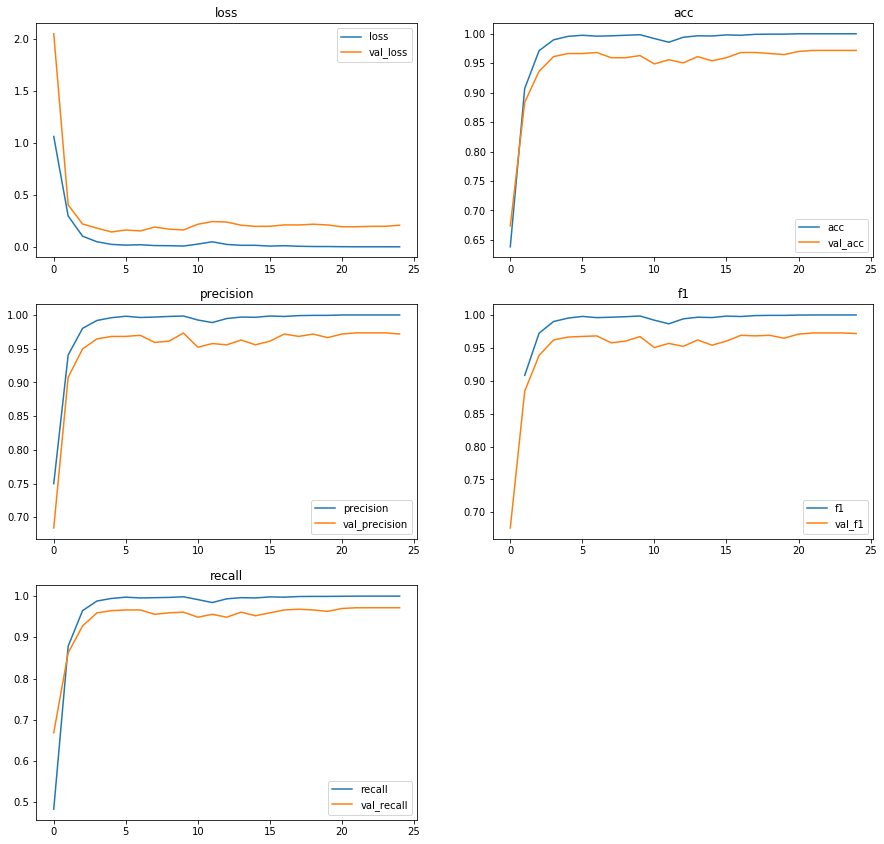

In [9]:
def plot_model(model):
    plots = [i for i in model.model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(15,25))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.model.history.history[p], label=p)
        plt.plot(model.model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

In [10]:
from keras.models import load_model

best_model = load_model('models/CNN_Model.h5', custom_objects={'recall': recall, 'precision': precision, 'f1': f1})

score, acc, recall, precision, f1 = best_model.evaluate(X_val, y_val, batch_size=64)

idx = len(results) + 1
results.loc[idx] = ['CNN', acc, precision, recall, f1]

print('Test score:', score)

results

 64/567 [==>...........................] - ETA: 5s

128/567 [=====>........................] - ETA: 4s

192/567 [=========>....................] - ETA: 3s

256/567 [============>.................] - ETA: 3s

320/567 [===============>..............] - ETA: 2s

384/567 [===================>..........] - ETA: 1s

448/567 [======================>.......] - ETA: 1s

512/567 [==========================>...] - ETA: 0s

567/567 [==============================] - 5s     


Test score: 0.143362437107


,Model,Accuracy,Precision,Recall,F1
1,CNN,0.96649,0.968142,0.964727,0.966421
